In [1]:
import scipy.io
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, minmax_scale

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import layers
from tensorflow import keras

In [3]:
from comsolml import read_data
from comsolml.filter import butter_lowpass_filter
from comsolml.custom_fk import tx_fk_plot, make_fk

In [4]:
sensorindex = [1, 2, 3, 4, 5, 6 , 7, 8, 9, 10, 11]
timesamples = 400
noisedb = -12
encoding_dim = 64
dt = 1e-6
dx = 3456*0.2e-3/12

In [5]:
mat = scipy.io.loadmat(Path().joinpath('..', 'data', 'input_synth', 'concat_traces.mat'))

In [6]:
X = mat['concat_traces'].astype('float32')

In [7]:
X = np.swapaxes(X, 2, 1)
X.dtype, X.shape

(dtype('float32'), (1250, 73, 401))

In [8]:
X = X[:,::6,:]

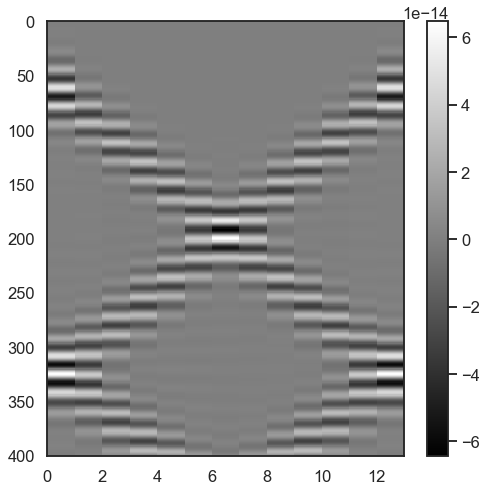

In [9]:
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(8,8))

plt.pcolormesh(X[0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()


plt.show()

In [10]:
X.shape[-1]

401

In [11]:
time_scaling = np.sqrt(np.arange(1, X.shape[-1]+1, dtype='float32'))
time_scaling = np.expand_dims(time_scaling, -1).T
time_scaling.shape

(1, 401)

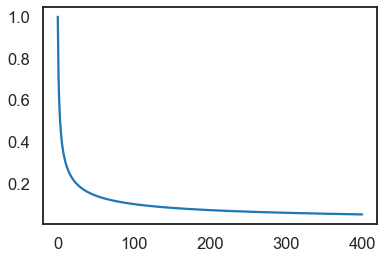

In [12]:
plt.plot(1/(time_scaling[0]))
plt.show()

In [13]:
#X = np.multiply(X, time_scaling)

In [14]:
X = np.divide(X, time_scaling)

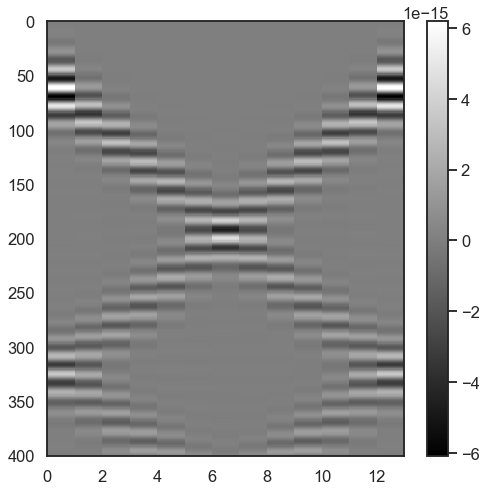

In [15]:
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(8,8))

plt.pcolormesh(X[0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()


plt.show()

In [16]:
labels = pd.read_csv(Path().joinpath('..', 'data', 'input_synth', 'labels.csv'))

In [17]:
labels.rename(columns={'thickness':'Thickness',
                       'depression':'Depression depth',
                       'pitting':'Pitting depth',
                       'depression_mu':'Depression location',
                       'depression_sigma':'Depression width',
                       'thickness_max':'Thickness maximum',
                       'thickness_min':'Thickness minimum',
                       'thickness_mean':'Thickness mean',
                       'thickness_median':'Thickness median',
                       'thickness_std':'Thickness std'}, inplace=True)

In [18]:
cases_ideal = labels[(labels['Depression depth'] == 0) & (labels['Pitting depth'] == 0)].index.tolist()

In [19]:
cases_ideal

[121, 230, 231, 679, 896, 1006, 1133]

In [20]:
from acoustics import generator
def make_noise(noisedb, noiseshape):
  noise = np.zeros(noiseshape, dtype='float32')
  noiselev = 10**(noisedb/10)
  for i in range(noiseshape[0]):
    for j in range(noiseshape[1]):
      noise[i, j, :] = generator.noise(noiseshape[2], color='white')*noiselev
  return noise

In [21]:
X_sample_c = X[:,:,:timesamples]/X.max()
X_sample_n = X_sample_c + make_noise(noisedb, X_sample_c.shape)
label_sample = labels

X_sample_n = np.expand_dims(X_sample_n, 1)
X_sample_c = np.expand_dims(X_sample_c, 1)

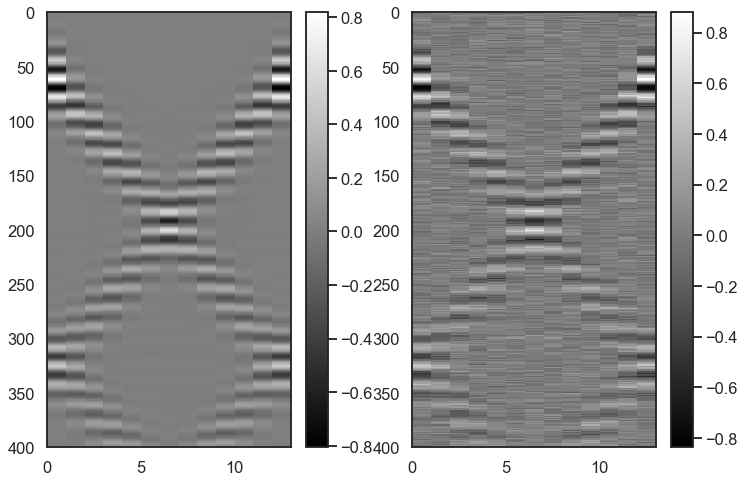

In [22]:
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.pcolormesh(X_sample_c[0,0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolormesh(X_sample_n[0,0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()


plt.show()

In [23]:
def pick_sensors(X_sample, sensorindex):
  # Sparse sensor mode:
  X_sample = np.take(X_sample, sensorindex, axis=2)
  if len(sensorindex)==1:
    X_sample = np.expand_dims(X_sample, 2)
  return X_sample

In [24]:
X_sample_n = pick_sensors(X_sample_n, sensorindex)
X_sample_c = pick_sensors(X_sample_c, sensorindex)
X_sample_n.shape, X_sample_c.shape

((1250, 1, 11, 400), (1250, 1, 11, 400))

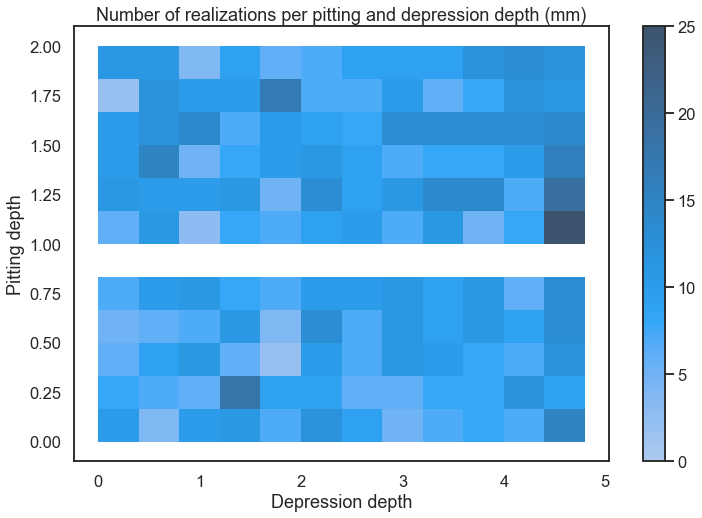

In [25]:
plt.figure(figsize=(12,8))
sns.histplot(data=label_sample, x="Depression depth", y="Pitting depth", discrete=False, cbar=True)
#sns.histplot(data=label_sample, x="pitting", binwidth=1)
plt.title('Number of realizations per pitting and depression depth (mm)')
plt.show()

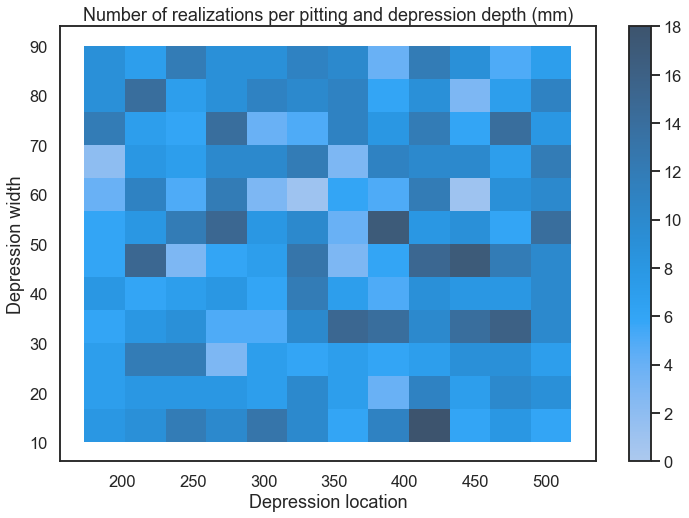

In [26]:
plt.figure(figsize=(12,8))
sns.histplot(data=label_sample, x="Depression location", y="Depression width", discrete=False, cbar=True)
#sns.histplot(data=label_sample, x="pitting", binwidth=1)
plt.title('Number of realizations per pitting and depression depth (mm)')
plt.show()

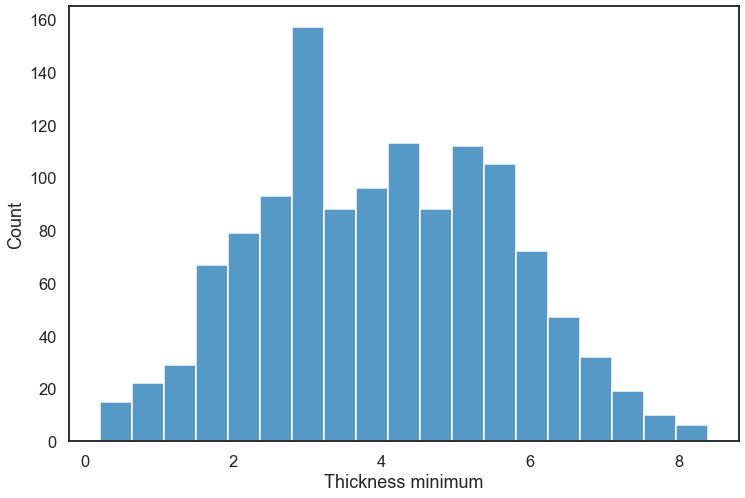

In [27]:
plt.figure(figsize=(12,8))
sns.histplot(data=label_sample, x="Thickness minimum", discrete=False)

plt.show()

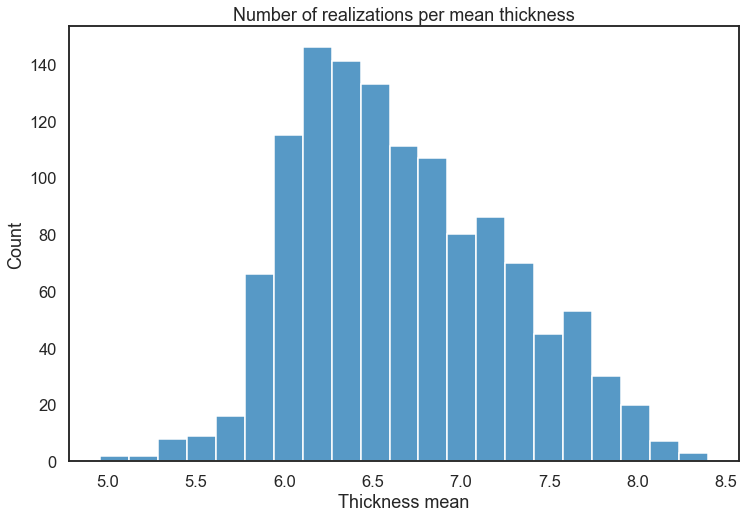

In [28]:
plt.figure(figsize=(12,8))
sns.histplot(data=label_sample, x="Thickness mean")
plt.title("Number of realizations per mean thickness")
plt.show()

# ML

In [29]:
x_train, x_test, y_train, y_test = train_test_split(X_sample_n, X_sample_c, test_size=0.2, random_state=43)

In [30]:
x_train_flat = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_flat = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
y_train_flat = y_train.reshape((len(y_train), np.prod(y_train.shape[1:])))
y_test_flat = y_test.reshape((len(y_test), np.prod(y_test.shape[1:])))

In [31]:
def make_autoencoder_flex(encoding_dim=64):

  input_trace = keras.Input(shape=(x_train_flat.shape[1],))
  # Add a Dense layer with a L1 activity regularizer
  encoded = layers.Dense(encoding_dim*16, activation='tanh')(input_trace)
  #encoded = layers.Dropout(0.2)(encoded)
  encoded = layers.Dense(encoding_dim*8, activation='tanh')(encoded)
  #encoded = layers.Dropout(0.2)(encoded)
  encoded = layers.Dense(encoding_dim*4, activation='tanh')(encoded)
  #encoded = layers.Dropout(0.2)(encoded)
  encoded = layers.Dense(encoding_dim*2, activation='tanh')(encoded)
  #encoded = layers.Dropout(0.2)(encoded)
  encoded = layers.Dense(encoding_dim, activation='tanh')(encoded)




  # "decoded" is the lossy reconstruction of the input
  decoded = layers.Dense(encoding_dim*2, activation='tanh')(encoded)
  #decoded = layers.Dropout(0.2)(decoded)
  decoded = layers.Dense(encoding_dim*4, activation='tanh')(decoded)
  #decoded = layers.Dropout(0.2)(decoded)
  decoded = layers.Dense(encoding_dim*8, activation='tanh')(decoded)
  #decoded = layers.Dropout(0.2)(decoded)
  decoded = layers.Dense(encoding_dim*16, activation='tanh')(decoded)
  decoded = layers.Dense(x_train_flat.shape[1], activation='linear')(decoded)

  # This model maps an input to its reconstruction
  autoencoder = keras.Model(input_trace, decoded)

  # This model maps an input to its encoded representation
  encoder = keras.Model(input_trace, encoded)

  # This is our encoded input
  encoded_input = keras.Input(shape=(encoding_dim,))
  deco = autoencoder.layers[-5](encoded_input)
  deco = autoencoder.layers[-4](deco)
  deco = autoencoder.layers[-3](deco)
  deco = autoencoder.layers[-2](deco)
  deco = autoencoder.layers[-1](deco)
  # create the decoder model
  decoder = keras.Model(encoded_input, deco)

  return autoencoder, encoder, decoder

Epoch 1/100
4/4 [==============================] - 2s 345ms/step - loss: 0.0127 - val_loss: 0.0091
Epoch 2/100
4/4 [==============================] - 1s 283ms/step - loss: 0.0082 - val_loss: 0.0065
Epoch 3/100
4/4 [==============================] - 1s 345ms/step - loss: 0.0058 - val_loss: 0.0046
Epoch 4/100
4/4 [==============================] - 1s 328ms/step - loss: 0.0042 - val_loss: 0.0035
Epoch 5/100
4/4 [==============================] - 1s 253ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 6/100
4/4 [==============================] - 1s 253ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 7/100
4/4 [==============================] - 1s 262ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 8/100
4/4 [==============================] - 1s 249ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 9/100
4/4 [==============================] - 1s 257ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 10/100
4/4 [==============================] - 1s 269ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 11/

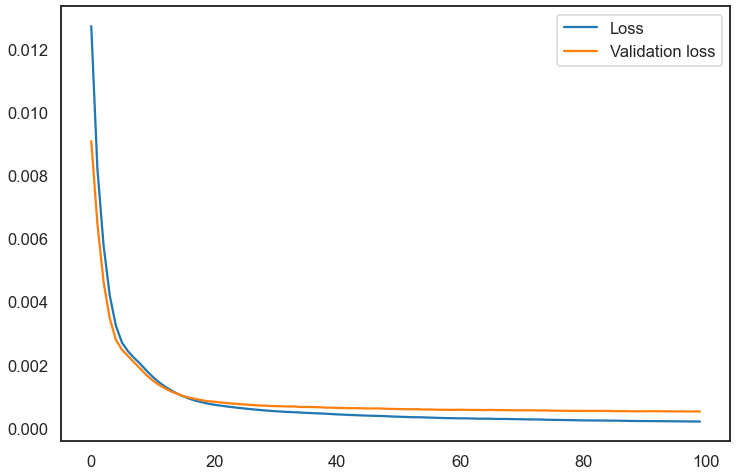

In [32]:
autoencoder, encoder, decoder = make_autoencoder_flex(encoding_dim=encoding_dim)
autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(x_train_flat, y_train_flat,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test_flat, y_test_flat))

  #sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Validation loss'])
plt.show()

In [33]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4400)]            0         
                                                                 
 dense (Dense)               (None, 1024)              4506624   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 128)               8320  

In [34]:
decoded_traces = autoencoder.predict(x_test_flat)
encoded_traces = encoder.predict(x_test_flat)

8/8 [==============================] - 0s 8ms/step


In [35]:
encoded_traces.shape, decoded_traces.shape

((250, 64), (250, 4400))

In [36]:
test_decoded_shaped = decoded_traces.reshape(len(decoded_traces), y_test.shape[1], y_test.shape[2], y_test.shape[3])

In [37]:
x_test.shape, test_decoded_shaped.shape

((250, 1, 11, 400), (250, 1, 11, 400))

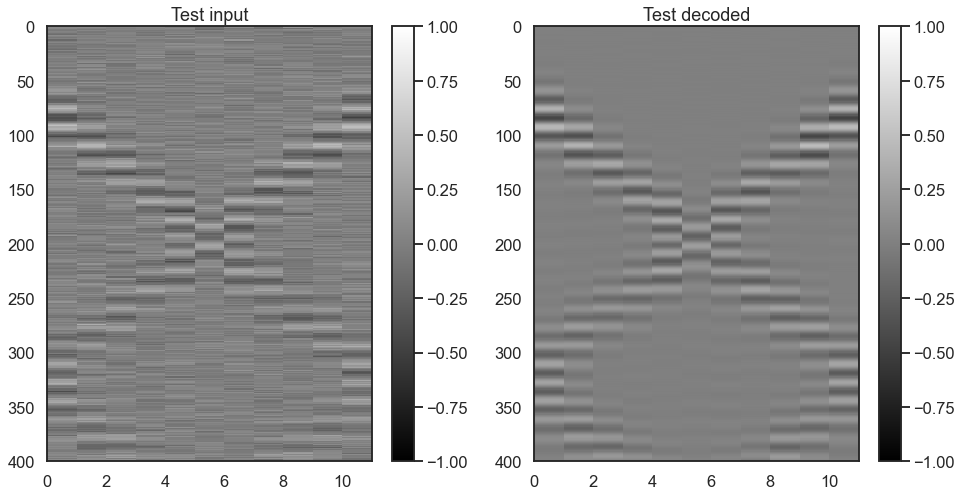

In [38]:
plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)
plt.pcolormesh(x_test[1, 0,:, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
#plt.grid()
plt.colorbar()
plt.title('Test input')

plt.subplot(1, 2, 2)
plt.pcolormesh(test_decoded_shaped[1, 0,:, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
#plt.grid()
plt.colorbar()
plt.title('Test decoded')



plt.show()

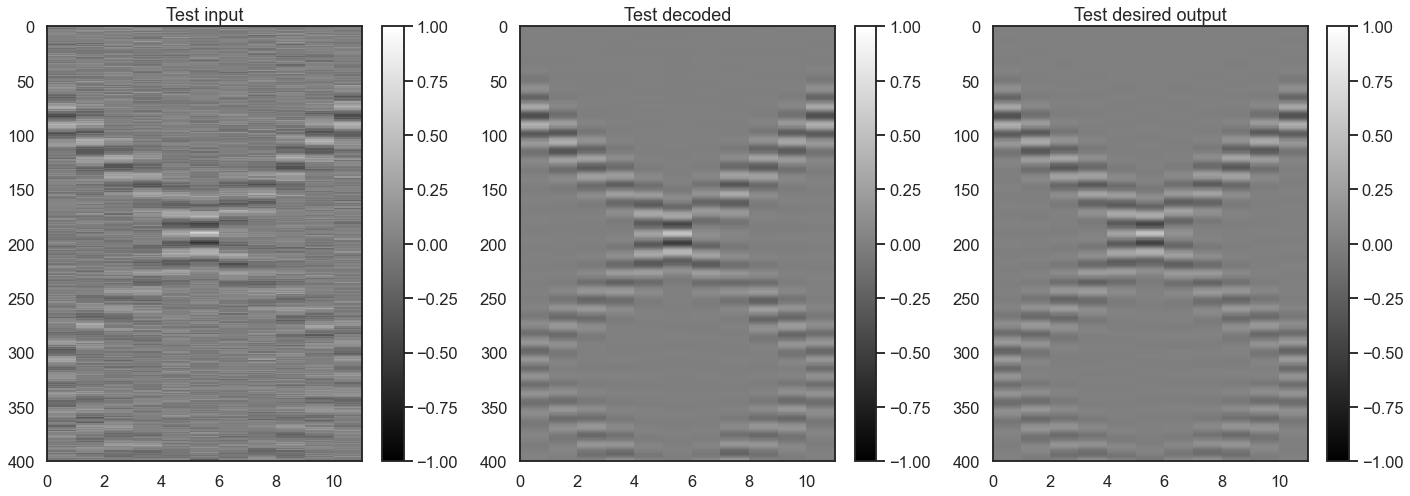

In [39]:
plt.figure(figsize=(24,8))

plt.subplot(1, 3, 1)
plt.pcolormesh(x_test[0, 0,:, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
#plt.grid()
plt.colorbar()
plt.title('Test input')

plt.subplot(1, 3, 2)
plt.pcolormesh(test_decoded_shaped[0, 0,:, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
#plt.grid()
plt.colorbar()
plt.title('Test decoded')

plt.subplot(1, 3, 3)
plt.pcolormesh(y_test[0, 0,:, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
#plt.grid()
plt.colorbar()
plt.title('Test desired output')



plt.show()

In [40]:
autoencoder.evaluate(x_test_flat, x_test_flat)

8/8 [==============================] - 0s 12ms/step - loss: 0.0044


0.004432738292962313

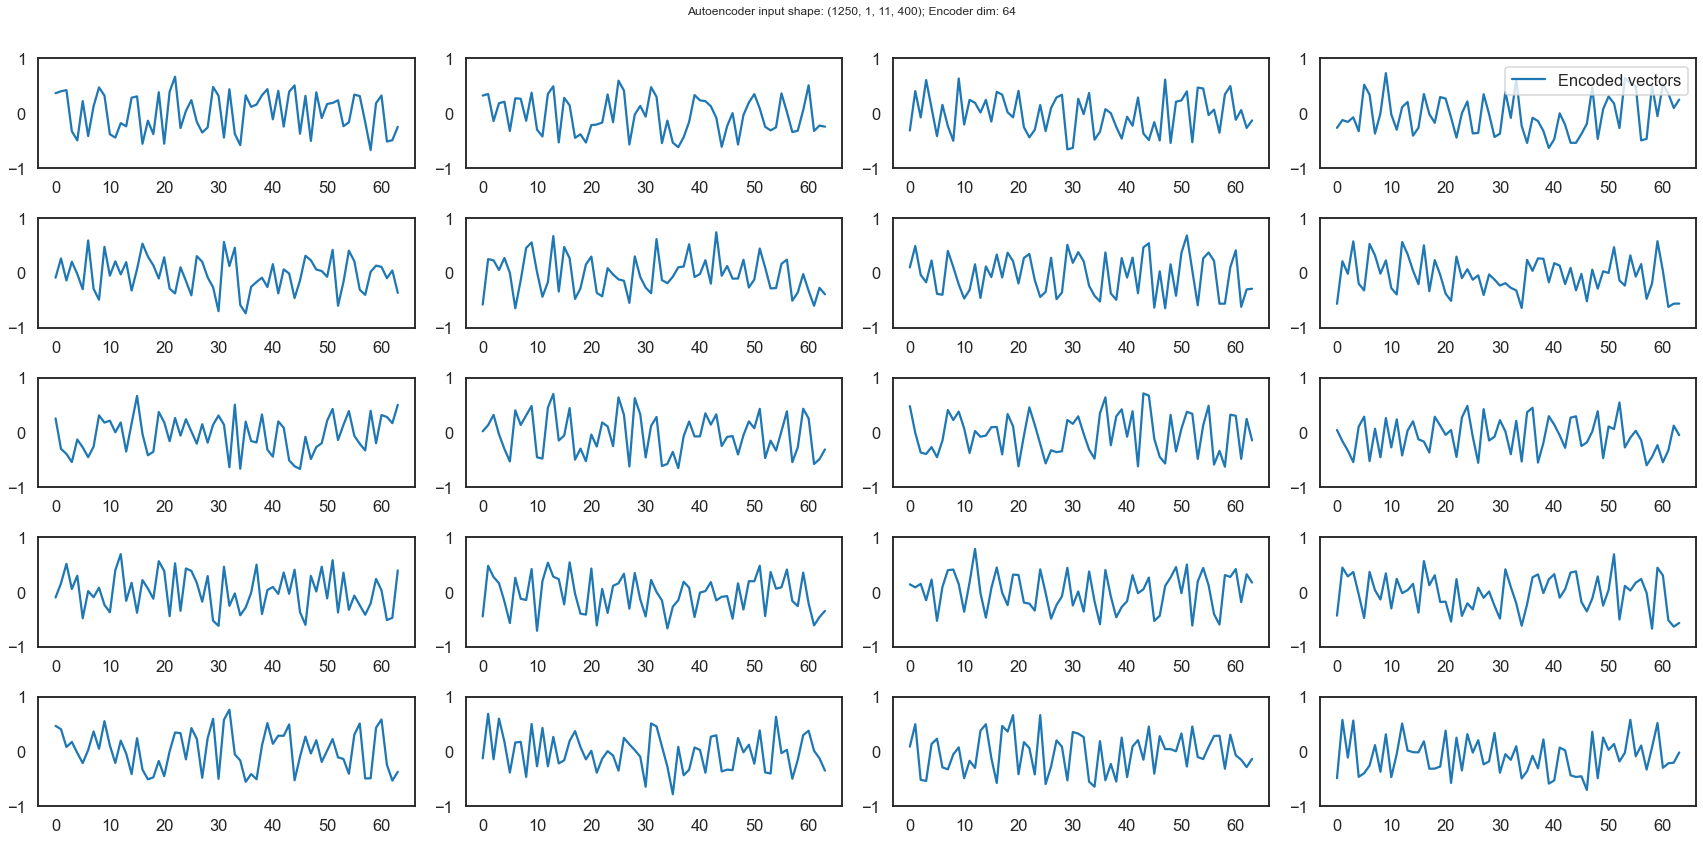

In [41]:
xnum = 5
ynum = 4
n = xnum*ynum

plt.figure(figsize=(24, 12))
for i in range(n):
    ax = plt.subplot(xnum, ynum, i + 1)

    #plt.plot(x_test_in[i])
    plt.plot(encoded_traces[i])
    #plt.plot(x_test_in[i])
    if i==ynum-1:
      #plt.legend(['Input trace', 'Decoded trace'], loc=1)
      plt.legend(['Encoded vectors'], loc=1)
    plt.ylim([-1, 1])

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle('Autoencoder input shape: '+ str(X_sample_n.shape) + '; Encoder dim: ' + str(encoding_dim), fontsize=12)
plt.show()

## Regression

In [42]:
X_sample_flat = X_sample_n.reshape((len(X_sample_n), np.prod(X_sample_n.shape[1:])))
X_sample_flat.shape

(1250, 4400)

In [43]:
encoded_all = encoder.predict(X_sample_flat)

40/40 [==============================] - 0s 9ms/step


In [44]:
#attributes = ['Thickness mean','Thickness minimum', 'Thickness std', 'Depression depth', 'Depression location','Pitting depth']
attributes = ['Thickness mean','Thickness minimum', 'Thickness std', 'Depression depth', 'Depression width','Pitting depth']

In [45]:
def make_regression_model():
  model = Sequential()
  model.add(Dense(encoding_dim, activation='tanh'))
  if encoding_dim > 32:
    model.add(Dense(32, activation='tanh'))
  if encoding_dim > 24:
    model.add(Dense(24, activation='tanh'))
  if encoding_dim > 16:
    model.add(Dense(16, activation='tanh'))
  if encoding_dim > 8:
    model.add(Dense(8, activation='tanh'))
  model.add(Dense(4, activation='tanh'))
  model.add(Dense(1, activation='linear'))
  return model

Thickness mean


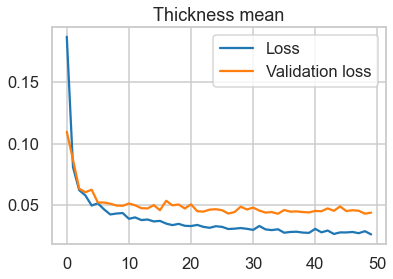

8/8 [==============================] - 0s 2ms/step - loss: 0.0438
loss: 0.04383202642202377
Thickness minimum


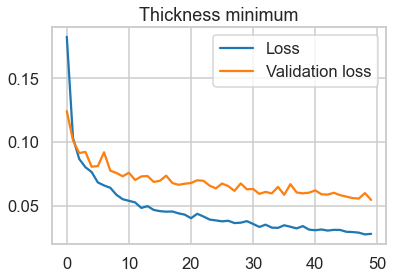

8/8 [==============================] - 0s 2ms/step - loss: 0.0546
loss: 0.05457894131541252
Thickness std


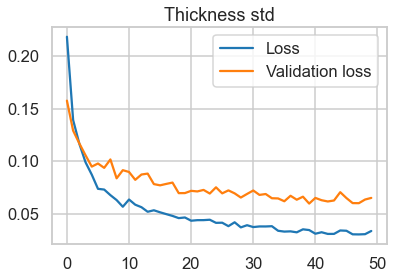

8/8 [==============================] - 0s 2ms/step - loss: 0.0649
loss: 0.06485706567764282
Depression depth


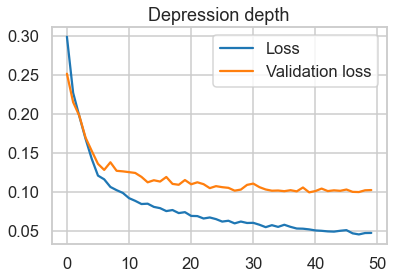

8/8 [==============================] - 0s 2ms/step - loss: 0.1025
loss: 0.10245350003242493
Depression width


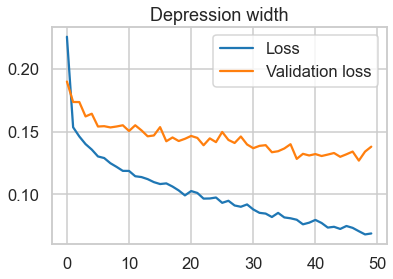

8/8 [==============================] - 0s 2ms/step - loss: 0.1381
loss: 0.13806025683879852
Pitting depth


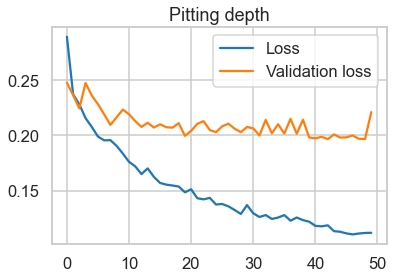

8/8 [==============================] - 0s 2ms/step - loss: 0.2211
loss: 0.22111691534519196


In [46]:
sns.set_style('whitegrid')
df_loss = pd.DataFrame(columns=attributes)
df_test = pd.DataFrame(columns=attributes)
df_predict = pd.DataFrame(columns=attributes)
regression_models = {}
min_max_scalers = {}
for attribute in attributes:
  print(attribute)
  y_reg = label_sample[[attribute]]

  min_max_scaler = MinMaxScaler()
  y_reg = min_max_scaler.fit_transform(y_reg)
  x_reg_train, x_reg_test, y_reg_train, y_reg_test_norm = train_test_split(encoded_all, y_reg, test_size=0.2, random_state=42)
  regression_model = make_regression_model()
  regression_model.compile(loss='mae', optimizer='adam')
  history = regression_model.fit(x_reg_train, y_reg_train.astype('float32'),
                epochs=50,
                batch_size=20,
                shuffle=True,
                verbose=0,
                validation_data=(x_reg_test, y_reg_test_norm.astype('float32')))

  plt.figure(figsize=(6, 4))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['Loss', 'Validation loss'])
  plt.title(attribute)
  plt.show()

  y_predict_norm = regression_model.predict(x_reg_test)
  y_predict = min_max_scaler.inverse_transform(y_predict_norm)
  y_reg_test = min_max_scaler.inverse_transform(y_reg_test_norm)
  loss = regression_model.evaluate(x_reg_test, y_reg_test_norm)
  print("loss: " + str(loss))
  df_loss.at[0, attribute] = loss
  df_test[attribute] = np.squeeze(y_reg_test)
  df_predict[attribute] = np.squeeze(y_predict)
  regression_models[attribute] = regression_model
  min_max_scalers[attribute] = min_max_scaler

In [47]:
scales = np.array([[4.5, 8.5],
                   [-0.5, 8.5],
                   [0, 1.8],
                   [-0.5, 5.5],
                   [150, 550],
                   [0, 2.25]])
scales = np.array([[4.5, 8.5],
                   [-0.5, 8.5],
                   [0, 1.8],
                   [-0.5, 5.5],
                   [0, 100],
                   [0, 2.25]])
df_scales = pd.DataFrame(scales.T, columns=df_test.columns)

In [48]:
def plot_reg_results(df_test, df_predict, df_loss, df_scales, perc=True, hue=None, title=None):
  sns.set_style('whitegrid')
  sns.set_context('talk')
  attributes = df_test.columns
  plt.figure(figsize=(20, 12))
  for i, attribute in enumerate(attributes):
    y_test_merge = np.squeeze(np.stack([df_test[[attribute]].to_numpy(), df_predict[[attribute]].to_numpy()]))
    df_test_merge = pd.DataFrame(y_test_merge.T, columns=['True [mm]', 'Predicted [mm]'])
    df_test_merge['abs_diff'] = abs(df_test_merge['True [mm]'] - df_test_merge['Predicted [mm]'])
    df_test_merge.quantile(q=0.75)['abs_diff']
    df_test_merge['75th percentile'] = np.where(df_test_merge['abs_diff'] < df_test_merge.quantile(q=0.75)['abs_diff'], True, False)
    plt.subplot(2, 3, i+1)
    if perc:
      sns.scatterplot(data=df_test_merge, x='True [mm]', y='Predicted [mm]', hue='75th percentile', alpha=0.5)
      plt.legend(loc='upper left', title='75th percentile')
    elif hue:
      sns.scatterplot(data=df_test_merge, x='True [mm]', y='Predicted [mm]', hue=hue, alpha=0.5, cmap="jet")
      plt.legend([],[], frameon=False)
    else:
      sns.scatterplot(data=df_test_merge, x='True [mm]', y='Predicted [mm]', alpha=0.5)
    textposx = 1*(df_scales.at[0, attribute] + (df_scales.at[1, attribute] - df_scales.at[0, attribute])*0.5)
    textposy = 1*(df_scales.at[0, attribute] + (df_scales.at[1, attribute] - df_scales.at[0, attribute])*0.05)
    textstring = "Normalized loss (mae): {:.6f}".format(df_loss.at[0, attribute])
    plt.text(textposx, textposy, textstring, fontsize=11, bbox=dict(facecolor='grey', alpha=0.5))
    plt.plot([df_test_merge['True [mm]'].min(), df_test_merge['True [mm]'].max()], [df_test_merge['True [mm]'].min(), df_test_merge['True [mm]'].max()], 'r--')
    plt.title(attribute)
    plt.xlim(df_scales.at[0, attribute], df_scales.at[1, attribute])
    plt.ylim(df_scales.at[0, attribute], df_scales.at[1, attribute])

  plt.tight_layout()
  plt.subplots_adjust(top=0.92)
  if title:
    plt.suptitle(title, fontsize=12)
  else:
    plt.suptitle('Autoencoder input shape: '+ str(X_sample_n.shape) + '; Encoder dim: ' + str(encoding_dim), fontsize=12)

  plt.show()

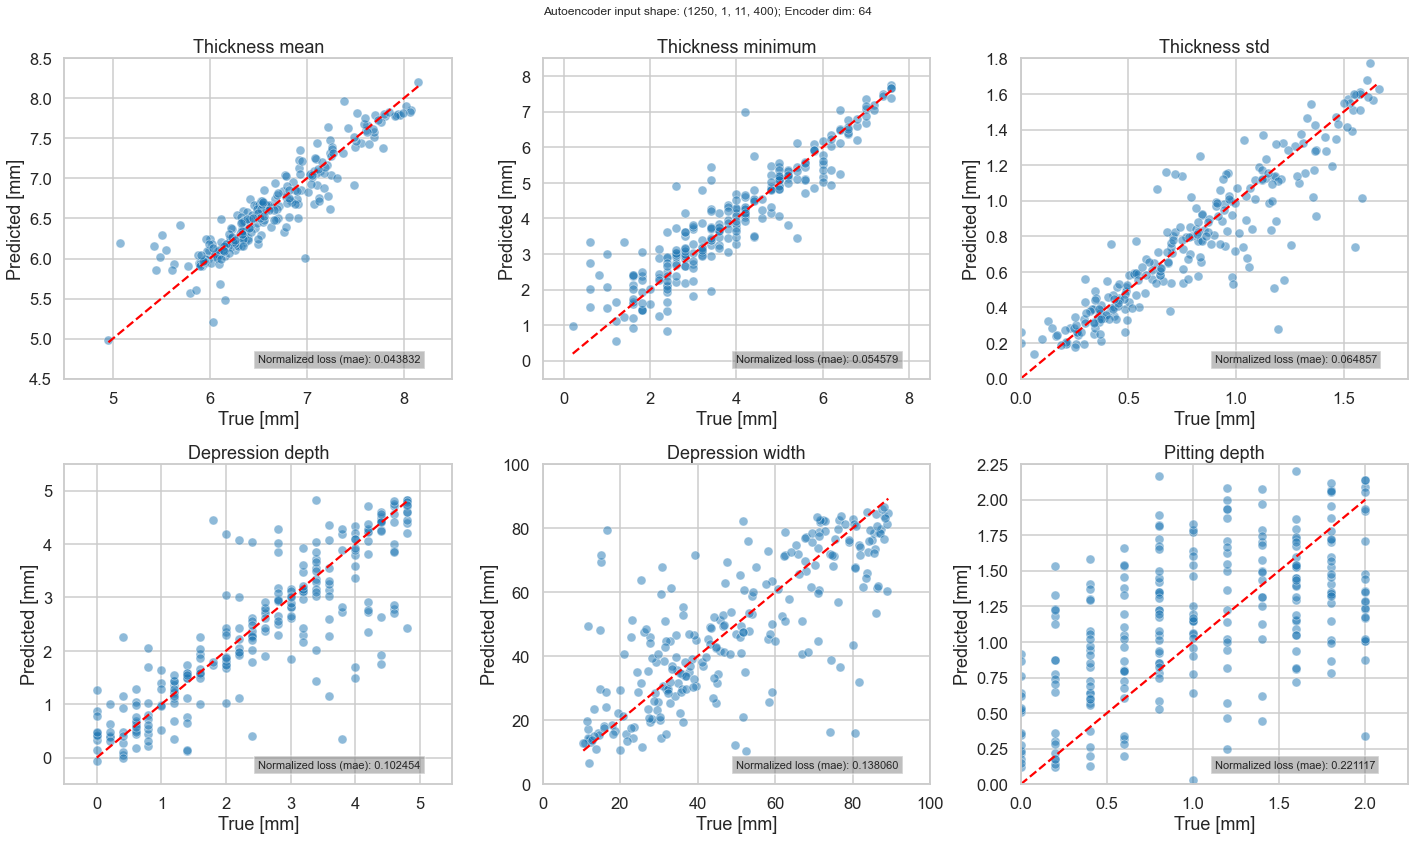

In [49]:
plot_reg_results(df_test, df_predict, df_loss, df_scales, perc=False)

## Direct Regression

Thickness mean


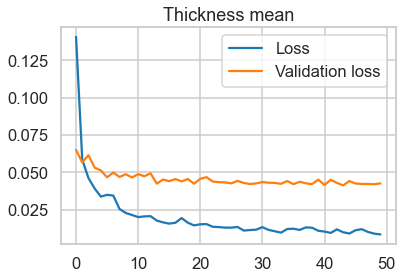

8/8 [==============================] - 0s 2ms/step - loss: 0.0426
loss: 0.0425976999104023
Thickness minimum


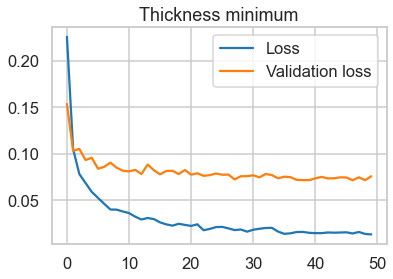

8/8 [==============================] - 0s 3ms/step - loss: 0.0759
loss: 0.07586206495761871
Thickness std


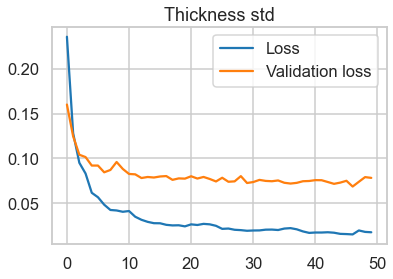

8/8 [==============================] - 0s 2ms/step - loss: 0.0783
loss: 0.07828278839588165
Depression depth


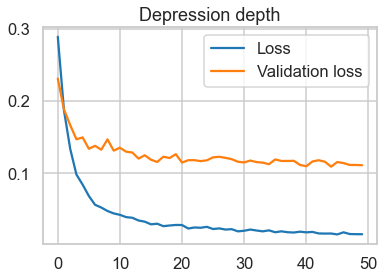

8/8 [==============================] - 0s 3ms/step - loss: 0.1113
loss: 0.11127245426177979
Depression width


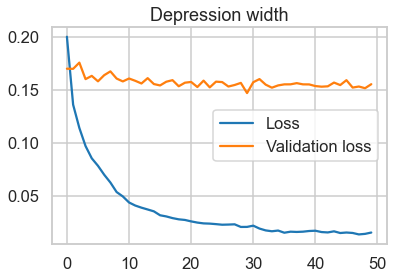

8/8 [==============================] - 0s 3ms/step - loss: 0.1552
loss: 0.15524306893348694
Pitting depth


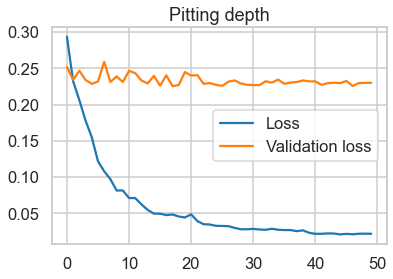

8/8 [==============================] - 0s 4ms/step - loss: 0.2300
loss: 0.2299553006887436


In [50]:
sns.set_style('whitegrid')
df_loss = pd.DataFrame(columns=attributes)
df_test = pd.DataFrame(columns=attributes)
df_predict = pd.DataFrame(columns=attributes)
for attribute in attributes:
  print(attribute)
  y_reg = label_sample[[attribute]]

  min_max_scaler = MinMaxScaler()
  y_reg = min_max_scaler.fit_transform(y_reg)
  x_reg_train, x_reg_test, y_reg_train, y_reg_test_norm = train_test_split(X_sample_n, y_reg, test_size=0.2, random_state=42)
  x_reg_train_flat = x_reg_train.reshape((len(x_reg_train), np.prod(x_reg_train.shape[1:])))
  x_reg_test_flat = x_reg_test.reshape((len(x_reg_test), np.prod(x_reg_test.shape[1:])))
  direct_regression_model = make_regression_model()
  #direct_regression_model = make_direct_regressor()
  direct_regression_model.compile(loss='mae', optimizer='adam')
  history = direct_regression_model.fit(x_reg_train_flat, y_reg_train.astype('float32'),
                epochs=50,
                batch_size=20,
                shuffle=True,
                verbose=0,
                validation_data=(x_reg_test_flat, y_reg_test_norm.astype('float32')))

  plt.figure(figsize=(6, 4))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['Loss', 'Validation loss'])
  plt.title(attribute)
  plt.show()

  y_predict_norm = direct_regression_model.predict(x_reg_test_flat)
  y_predict = min_max_scaler.inverse_transform(y_predict_norm)
  y_reg_test = min_max_scaler.inverse_transform(y_reg_test_norm)
  loss = direct_regression_model.evaluate(x_reg_test_flat, y_reg_test_norm)
  print("loss: " + str(loss))
  df_loss.at[0, attribute] = loss
  df_test[attribute] = np.squeeze(y_reg_test)
  df_predict[attribute] = np.squeeze(y_predict)

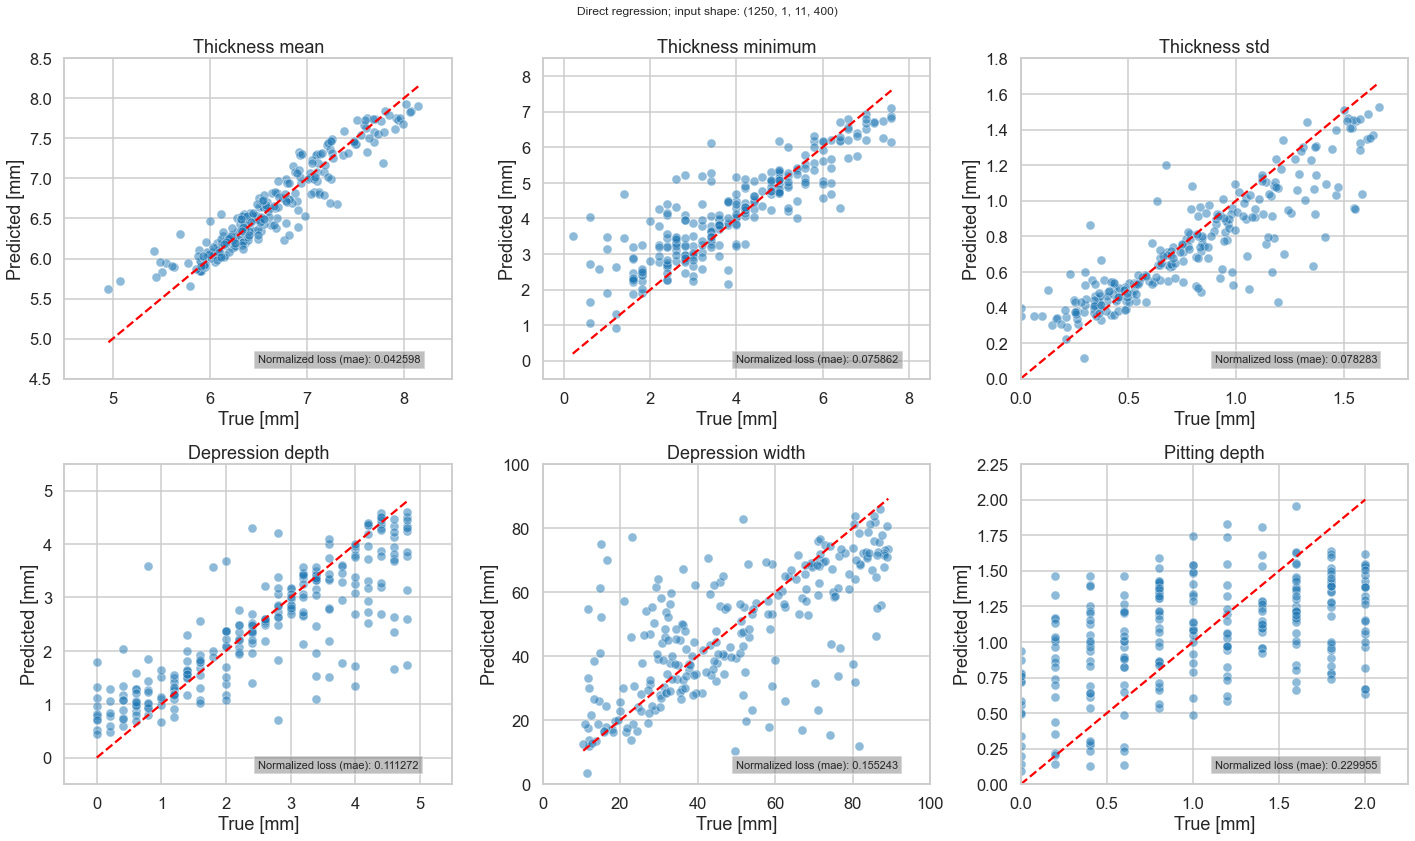

In [51]:
plot_reg_results(df_test, df_predict, df_loss, df_scales, perc=False, title='Direct regression; input shape: '+ str(X_sample_n.shape))

# Real data

In [52]:
realdatapath = '../data/input_real/Waveforms_clock_pos/'
df_waveforms, df_time = read_data.read_waveforms(realdatapath)

20220210-01oc-040kHz.csv
20220210-01oc-041kHz.csv
20220210-01oc-042kHz.csv
20220210-01oc-043kHz.csv
20220210-01oc-044kHz.csv
20220210-01oc-045kHz.csv
20220210-01oc-046kHz.csv
20220210-01oc-047kHz.csv
20220210-01oc-048kHz.csv
20220210-01oc-049kHz.csv
20220210-01oc-050kHz.csv
20220210-01oc-051kHz.csv
20220210-01oc-052kHz.csv
20220210-01oc-053kHz.csv
20220210-01oc-054kHz.csv
20220210-01oc-055kHz.csv
20220210-01oc-056kHz.csv
20220210-01oc-057kHz.csv
20220210-01oc-058kHz.csv
20220210-01oc-059kHz.csv
20220210-01oc-060kHz.csv
20220210-01oc-061kHz.csv
20220210-01oc-062kHz.csv
20220210-01oc-063kHz.csv
20220210-01oc-064kHz.csv
20220210-01oc-065kHz.csv
20220210-01oc-066kHz.csv
20220210-01oc-067kHz.csv
20220210-01oc-068kHz.csv
20220210-01oc-069kHz.csv
20220210-01oc-070kHz.csv
20220210-01oc-071kHz.csv
20220210-01oc-072kHz.csv
20220210-01oc-073kHz.csv
20220210-01oc-074kHz.csv
20220210-01oc-075kHz.csv
20220210-01oc-076kHz.csv
20220210-01oc-077kHz.csv
20220210-01oc-078kHz.csv
20220210-01oc-079kHz.csv


In [53]:
first_iter = True
for freq in np.unique(df_waveforms.columns):
  measurement_temp = df_waveforms[freq].to_numpy()[900:4100:5,:-1]
  measurement_temp = measurement_temp/measurement_temp.max()
  if first_iter:
    measurements = np.expand_dims(measurement_temp, axis=0)
    first_iter = False
  else:
    measurements = np.concatenate((measurements, np.expand_dims(measurement_temp, axis=0)), axis=0)

In [54]:
measurements = measurements[:,:timesamples,:]
measurements.shape

(41, 400, 11)

In [55]:
# Filtering
applyfilter = False
if applyfilter:
  for panelno in range(41):
    frq = panelno+40
    cutoff = frq*1.2*1000
    filtered_temp = butter_lowpass_filter(measurements[panelno], cutoff, 4)
    measurements[panelno] = filtered_temp/filtered_temp.max()

In [56]:
measurements.max()

1.0

In [57]:
tracebalancing = False
if tracebalancing:
  for panelno in range(41):
    tracemax = np.zeros(shape=measurements[panelno,1,:].shape)
    for traceno in range(len(tracemax)):
      tracemax[traceno] = measurements[panelno,:,traceno].max()
    measurements[panelno] = np.divide(measurements[panelno], tracemax)

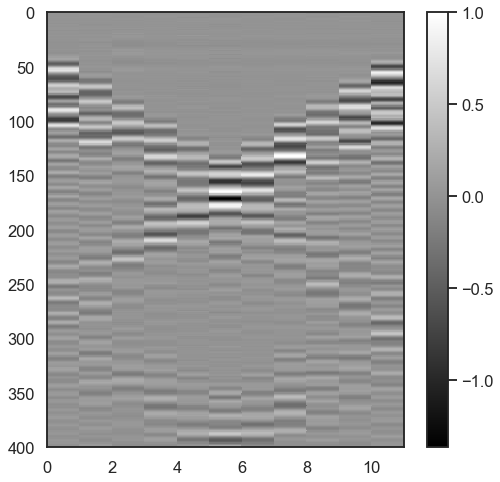

In [58]:
sns.set_style('white')
plt.figure(figsize=(8,8))
plt.pcolor(measurements[20,:,:], cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

In [59]:
measurements_flat = measurements.reshape((len(measurements), np.prod(measurements.shape[1:])))
real_autoencoded = autoencoder.predict(measurements_flat)

2/2 [==============================] - 0s 30ms/step


In [60]:
real_autoencoded.shape, measurements.shape

((41, 4400), (41, 400, 11))

In [61]:
real_autoencoded_shaped = real_autoencoded.reshape(41, 11, timesamples)
real_autoencoded_shaped.shape

(41, 11, 400)

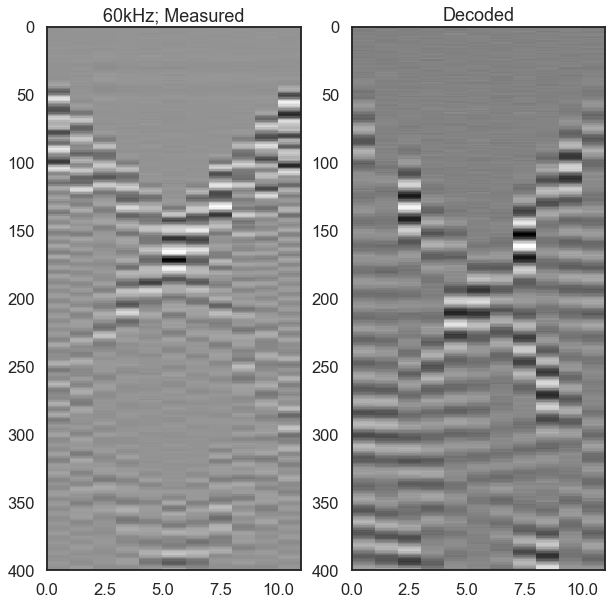

In [62]:
freq = 60
sns.set_style('white')
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.pcolormesh(measurements[freq-40,:,:], cmap='gray')
plt.gca().invert_yaxis()
plt.title(str(freq) + 'kHz; Measured')
plt.subplot(1,2,2)
plt.pcolormesh(real_autoencoded_shaped[freq-40,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.title('Decoded')
plt.show()

In [63]:
#stop

In [64]:
real_encoded = encoder.predict(measurements_flat)

2/2 [==============================] - 0s 12ms/step


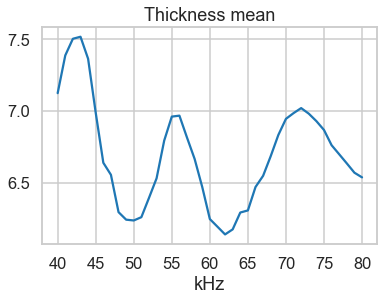

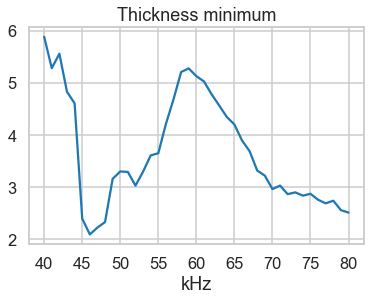

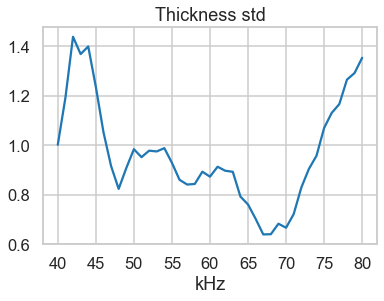

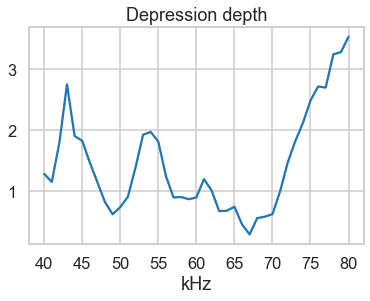

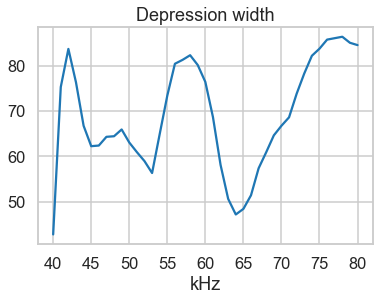

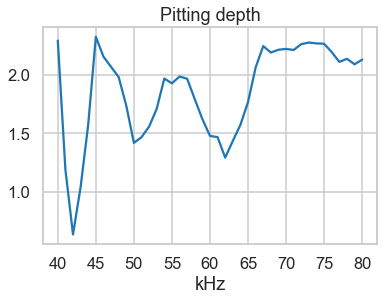

In [65]:
sns.set_context('talk')
sns.set_style('whitegrid')
real_prediction = {}
for attribute in attributes:
  real_prediction_norm = regression_models[attribute](real_encoded)

  real_prediction[attribute] = min_max_scalers[attribute].inverse_transform(real_prediction_norm)
  plt.plot(real_prediction[attribute])
  plt.title(attribute)
  plt.xticks(range(0, 41, 5), range(40, 81, 5))
  plt.xlabel('kHz')
  plt.show()

# FK

In [66]:
def make_fk_samples(X, dt, dx, fk_maxfreq=120e3, returncomplex=False, returndb=False):
  X_fk = np.zeros(shape=X.shape)
  X_fk = np.swapaxes(X_fk, 2, 3)
  X_fk = np.expand_dims(X_fk, 2)
  X_fk = np.repeat(X_fk, 2, axis=2)
  print(X_fk.shape)
  for i in range(X_fk.shape[0]):
    for j in range(X_fk.shape[1]):
      if returncomplex:
        fk_temp, x_array, f_array = make_fk(X[i,j,:,:].T, dt, dx)
        fk_temp_real = np.real(fk_temp)
        fk_temp_im = np.imag(fk_temp)
        X_fk[i,j,0,:,:] = fk_temp_real/400
        X_fk[i,j,1,:,:] = fk_temp_im/400

      else:
        fk_temp, x_array, f_array = make_fk(X[i,j,:,:].T, dt, dx)
        fk_temp_amp = np.abs(fk_temp)/np.max(np.abs(fk_temp))
        if returndb:
          fk_temp_amp = np.log10(fk_temp_amp)
        fk_temp_amp = minmax_scale(fk_temp_amp)
        fk_temp_angle = np.unwrap(np.angle(fk_temp))
        fk_temp_angle = minmax_scale(fk_temp_angle)
        X_fk[i,j,0,:,:] = fk_temp_amp
        X_fk[i,j,1,:,:] = fk_temp_angle



  #fk_maxfreq = 120e3
  fk_f_indeces = np.where((f_array >= 0) & (f_array <= fk_maxfreq))

  f_array = f_array[fk_f_indeces[0]]
  X_fk = X_fk[:,:,:,fk_f_indeces[0],:]

  return X_fk, x_array, f_array

In [67]:
X_sample_n_fk, x_array, f_array = make_fk_samples(X_sample_n, dt, dx, returndb=False)
X_sample_c_fk, x_array, f_array = make_fk_samples(X_sample_c, dt, dx, returndb=False)

(1250, 1, 2, 400, 11)
(1250, 1, 2, 400, 11)


In [68]:
X_sample_n.shape

(1250, 1, 11, 400)

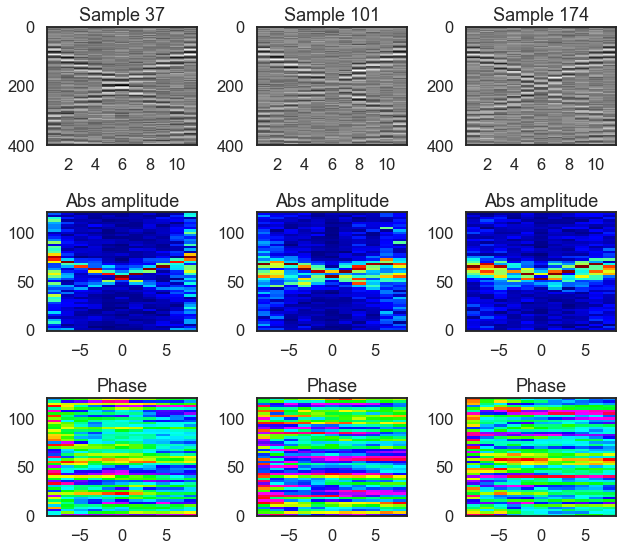

In [69]:
cases = [37, 101, 174]
clock_array = np.array([2, 4, 6, 8, 10])
sns.set_style("white")
sns.set_context("talk")
plt.figure(figsize=(3*len(cases),8))
for i, case in enumerate(cases):
  plt.subplot(3, len(cases), i+1)
  #plt.pcolormesh(x_array, f_array/1e3, X_sample_c_fk[case,0,:,:], cmap='jet')
  plt.pcolormesh(X_sample_n[case,0,:,:].T, cmap='gray')
  plt.gca().invert_yaxis()
  plt.xticks(ticks=clock_array-0.5, labels=clock_array)
  #plt.title('Sample ' + str(case) + '; Thickness min: ' + str(np.round(labels.iloc[case]['Thickness minimum']*0.2, decimals=1)))

  plt.title('Sample ' + str(case))
  plt.subplot(3, len(cases), i+len(cases)+1)
  plt.pcolormesh(x_array, f_array/1e3, X_sample_n_fk[case,0,0,:,:], cmap='jet')
  plt.title('Abs amplitude')
  #plt.colorbar()
  plt.subplot(3, len(cases), i+2*len(cases)+1)
  plt.pcolormesh(x_array, f_array/1e3, X_sample_n_fk[case,0,1,:,:], cmap='hsv')
  plt.title('Phase')
  #plt.colorbar()
  #plt.colorbar()
plt.tight_layout()
plt.show()

In [70]:
'''
cases = [37, 101, 174]
clock_array = np.array([2, 4, 6, 8, 10])
sns.set_style("white")
sns.set_context("talk")
plt.figure(figsize=(3*len(cases),8))
for i, case in enumerate(cases):
  plt.subplot(1, len(cases), i+1)
  plt.pcolormesh(x_array, f_array/1e3, X_sample_n_fk[case,0,:,:], cmap='jet')
  plt.title('Abs amplitude')#plt.title('Sample ' + str(case) + '; Thickness min: ' + str(np.round(labels.iloc[case]['Thickness minimum']*0.2, decimals=1)))
plt.tight_layout()
plt.show()
'''

'\ncases = [37, 101, 174]\nclock_array = np.array([2, 4, 6, 8, 10])\nsns.set_style("white")\nsns.set_context("talk")\nplt.figure(figsize=(3*len(cases),8))\nfor i, case in enumerate(cases):\n  plt.subplot(1, len(cases), i+1)\n  plt.pcolormesh(x_array, f_array/1e3, X_sample_n_fk[case,0,:,:], cmap=\'jet\')\n  plt.title(\'Abs amplitude\')#plt.title(\'Sample \' + str(case) + \'; Thickness min: \' + str(np.round(labels.iloc[case][\'Thickness minimum\']*0.2, decimals=1)))\nplt.tight_layout()\nplt.show()\n'

In [71]:
amp_only = True
if amp_only:
  X_sample_n_fk = X_sample_n_fk[:,:,0,:,:]
  X_sample_c_fk = X_sample_c_fk[:,:,0,:,:]

In [72]:
X_sample_n_fk.shape, X_sample_n_fk.max(), X_sample_c_fk.shape

((1250, 1, 49, 11), 1.0000000000000002, (1250, 1, 49, 11))

In [73]:
x_train_fk, x_test_fk, y_train_fk, y_test_fk = train_test_split(X_sample_n_fk, X_sample_c_fk, test_size=0.2, random_state=42)

In [74]:
x_train_flat_fk = x_train_fk.reshape((len(x_train_fk), np.prod(x_train_fk.shape[1:])))
x_test_flat_fk = x_test_fk.reshape((len(x_test_fk), np.prod(x_test_fk.shape[1:])))
y_train_flat_fk = y_train_fk.reshape((len(y_train_fk), np.prod(y_train_fk.shape[1:])))
y_test_flat_fk = y_test_fk.reshape((len(y_test_fk), np.prod(y_test_fk.shape[1:])))

In [75]:
x_train_flat_fk.shape, x_test_flat_fk.shape, y_train_flat_fk.shape, y_test_flat_fk.shape

((1000, 539), (250, 539), (1000, 539), (250, 539))

In [76]:
def make_autoencoder_fk(encoding_dim=16):

  input_trace = keras.Input(shape=(x_train_flat_fk.shape[1],))
  # Add a Dense layer with a L1 activity regularizer
  encoded = layers.Dense(encoding_dim*16, activation='relu')(input_trace)
  #encoded = layers.Dropout(0.2)(encoded)
  encoded = layers.Dense(encoding_dim*8, activation='relu')(encoded)
  #encoded = layers.Dropout(0.2)(encoded)
  encoded = layers.Dense(encoding_dim*4, activation='relu')(encoded)
  #encoded = layers.Dropout(0.2)(encoded)
  encoded = layers.Dense(encoding_dim*2, activation='relu')(encoded)
  #encoded = layers.Dropout(0.2)(encoded)
  encoded = layers.Dense(encoding_dim, activation='relu')(encoded)

  # "decoded" is the lossy reconstruction of the input
  decoded = layers.Dense(encoding_dim*2, activation='relu')(encoded)
  #decoded = layers.Dropout(0.2)(decoded)
  decoded = layers.Dense(encoding_dim*4, activation='relu')(decoded)
  #decoded = layers.Dropout(0.2)(decoded)
  decoded = layers.Dense(encoding_dim*8, activation='relu')(decoded)
  #decoded = layers.Dropout(0.2)(decoded)
  decoded = layers.Dense(encoding_dim*16, activation='relu')(decoded)
  decoded = layers.Dense(x_train_flat_fk.shape[1], activation='linear')(decoded)

  # This model maps an input to its reconstruction
  autoencoder = keras.Model(input_trace, decoded)

  # This model maps an input to its encoded representation
  encoder = keras.Model(input_trace, encoded)

  # This is our encoded input
  encoded_input = keras.Input(shape=(encoding_dim,))
  deco = autoencoder.layers[-5](encoded_input)
  deco = autoencoder.layers[-4](deco)
  deco = autoencoder.layers[-3](deco)
  deco = autoencoder.layers[-2](deco)
  deco = autoencoder.layers[-1](deco)
  # create the decoder model
  decoder = keras.Model(encoded_input, deco)

  return autoencoder, encoder, decoder

Epoch 1/100
4/4 [==============================] - 2s 137ms/step - loss: 0.0570 - val_loss: 0.0483
Epoch 2/100
4/4 [==============================] - 0s 40ms/step - loss: 0.0389 - val_loss: 0.0253
Epoch 3/100
4/4 [==============================] - 0s 43ms/step - loss: 0.0220 - val_loss: 0.0197
Epoch 4/100
4/4 [==============================] - 0s 45ms/step - loss: 0.0192 - val_loss: 0.0187
Epoch 5/100
4/4 [==============================] - 0s 39ms/step - loss: 0.0185 - val_loss: 0.0180
Epoch 6/100
4/4 [==============================] - 0s 36ms/step - loss: 0.0179 - val_loss: 0.0175
Epoch 7/100
4/4 [==============================] - 0s 37ms/step - loss: 0.0174 - val_loss: 0.0172
Epoch 8/100
4/4 [==============================] - 0s 38ms/step - loss: 0.0171 - val_loss: 0.0169
Epoch 9/100
4/4 [==============================] - 0s 39ms/step - loss: 0.0169 - val_loss: 0.0167
Epoch 10/100
4/4 [==============================] - 0s 38ms/step - loss: 0.0167 - val_loss: 0.0165
Epoch 11/100
4/4 [

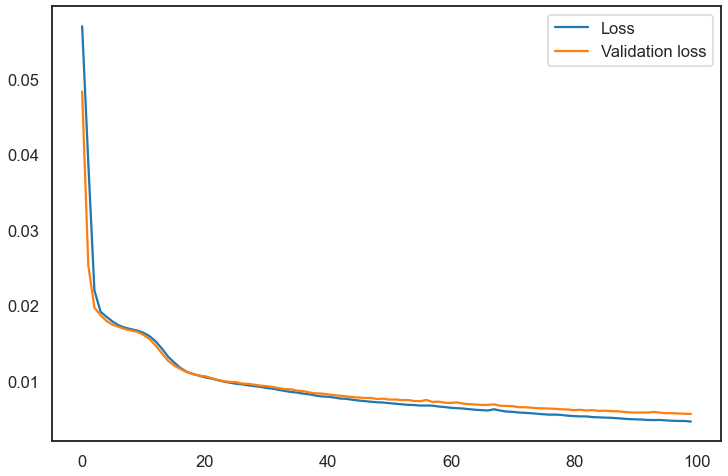

In [77]:
autoencoder_fk, encoder_fk, decoder_fk = make_autoencoder_fk(encoding_dim=24)
autoencoder_fk.compile(optimizer='adam', loss='mse')

history = autoencoder_fk.fit(x_train_flat_fk, y_train_flat_fk,
              epochs=100,
              batch_size=256,
              shuffle=True,
              validation_data=(x_test_flat_fk, y_test_flat_fk))

  #sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Validation loss'])
plt.show()

In [78]:
decoded_traces_fk = autoencoder_fk.predict(x_test_flat_fk)
encoded_traces_fk = encoder_fk.predict(x_test_flat_fk)

8/8 [==============================] - 0s 3ms/step


In [79]:
decoded_shaped_fk = decoded_traces_fk.reshape(len(decoded_traces_fk), y_test_fk.shape[1], y_test_fk.shape[2], y_test_fk.shape[3])

In [80]:
decoded_shaped_fk.shape, x_test_fk.shape

((250, 1, 49, 11), (250, 1, 49, 11))

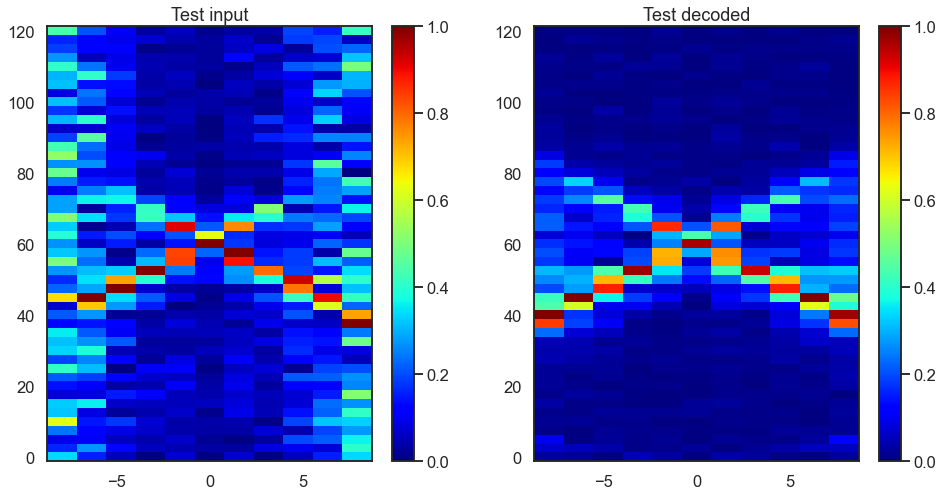

In [81]:
plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)
plt.pcolormesh(x_array, f_array/1e3, x_test_fk[0, 0,:, :], cmap='jet', vmin=0, vmax=1)
#plt.grid()
plt.colorbar()
plt.title('Test input')

plt.subplot(1, 2, 2)
plt.pcolormesh(x_array, f_array/1e3, decoded_shaped_fk[0, 0,:, :], cmap='jet', vmin=0, vmax=1)
#plt.grid()
plt.colorbar()
plt.title('Test decoded')



plt.show()

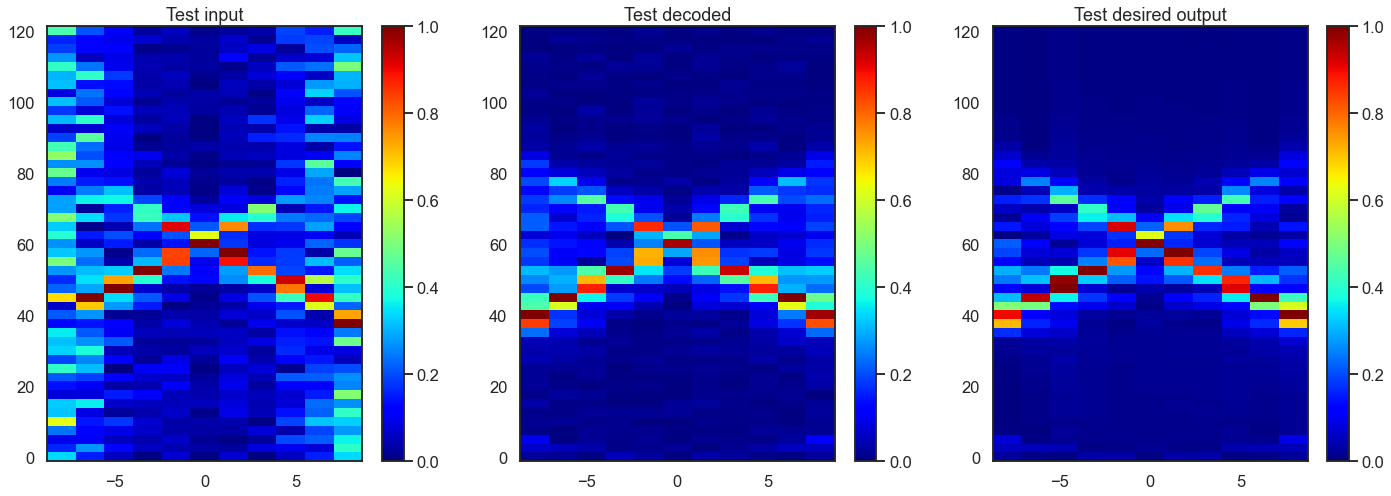

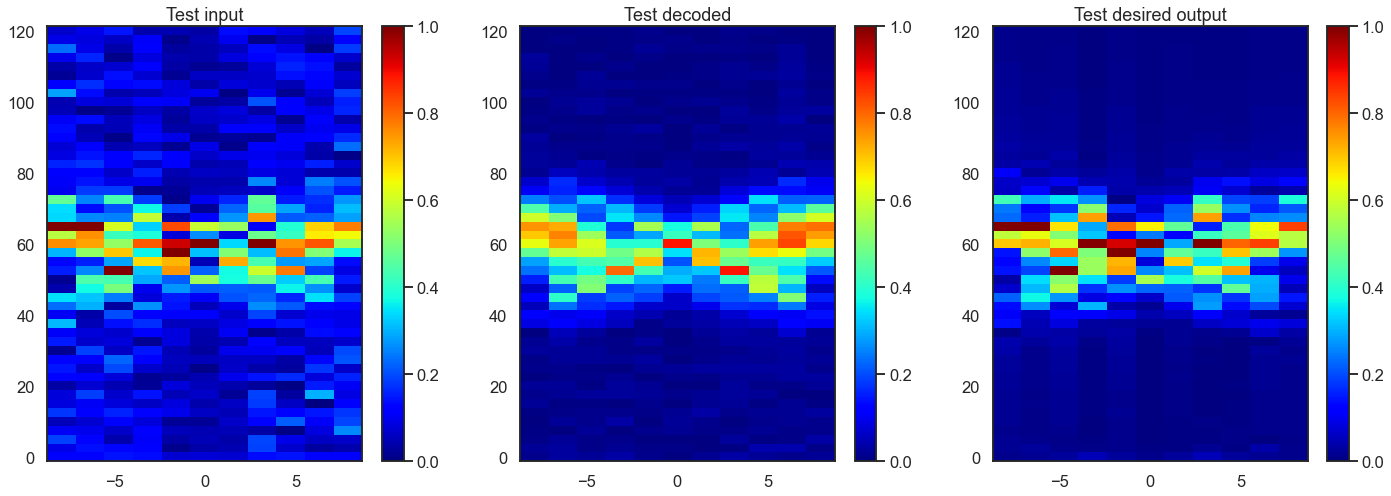

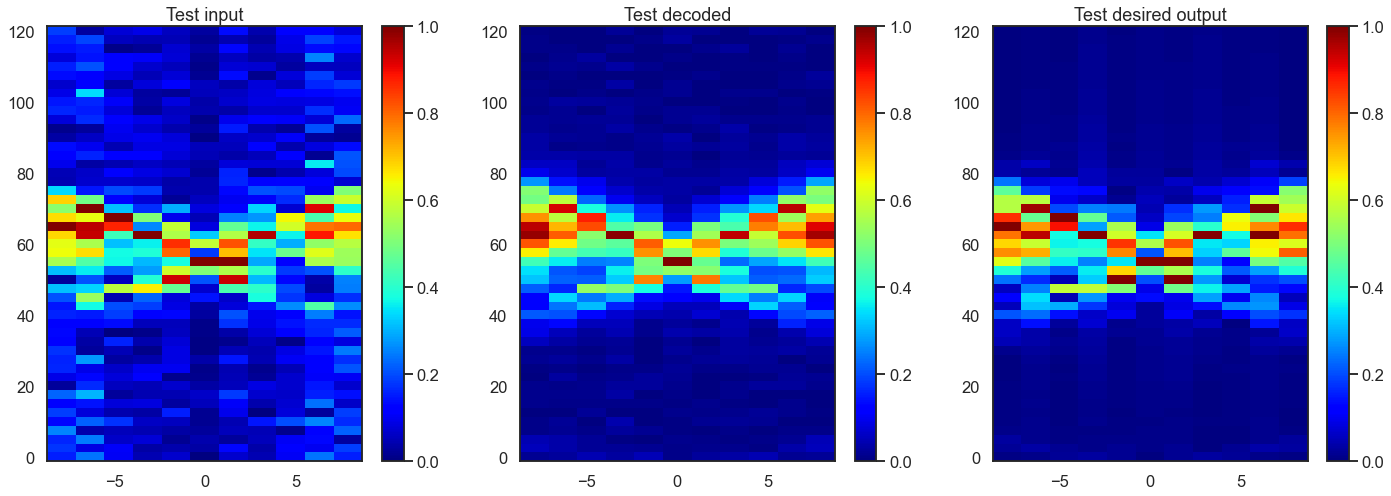

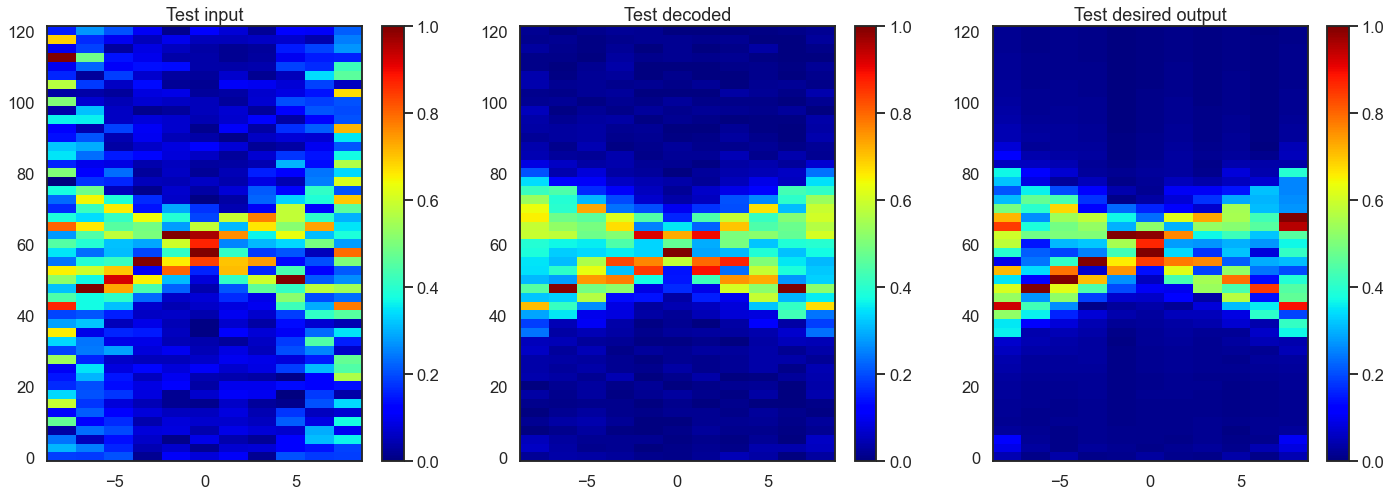

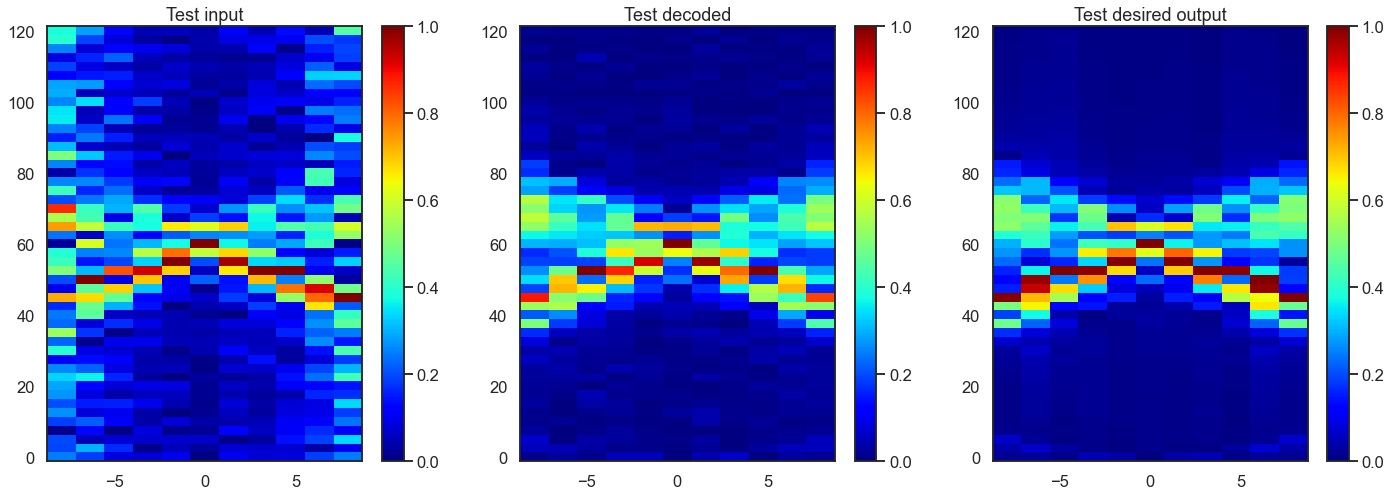

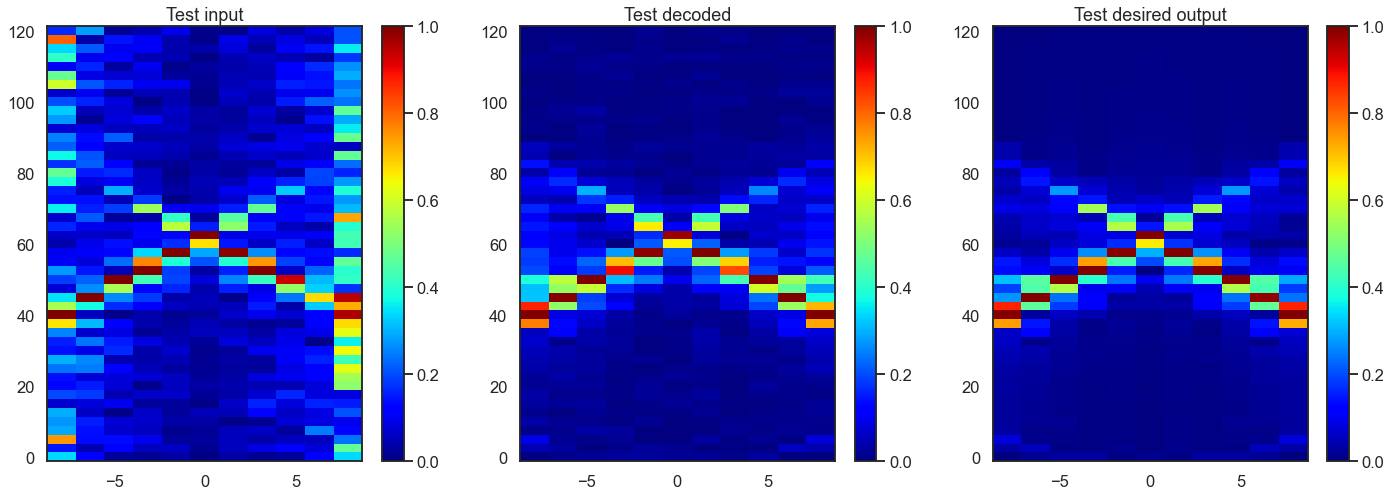

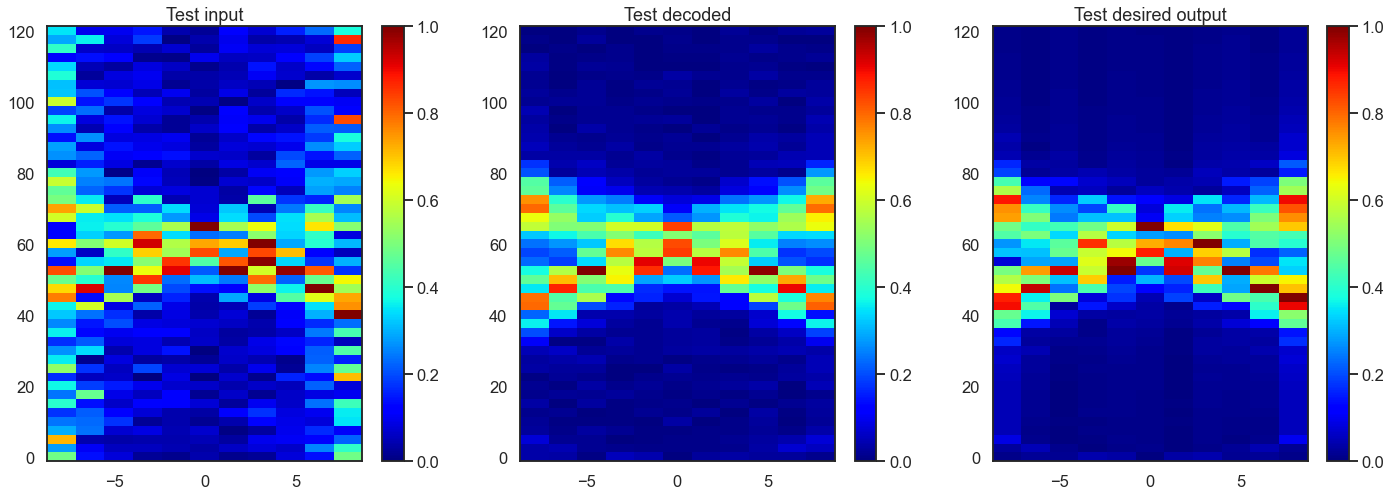

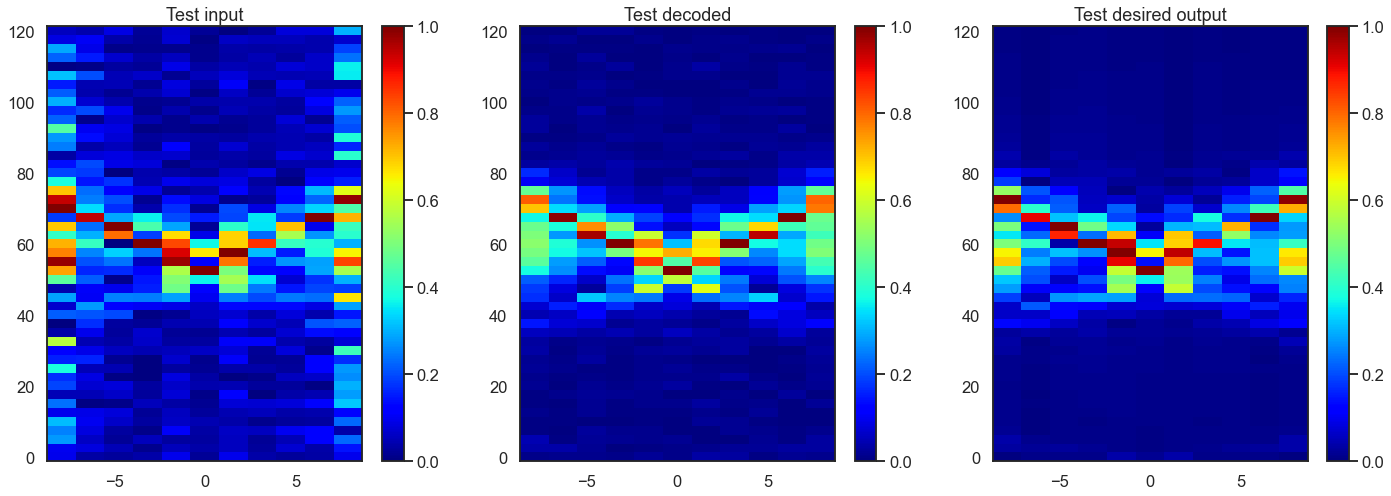

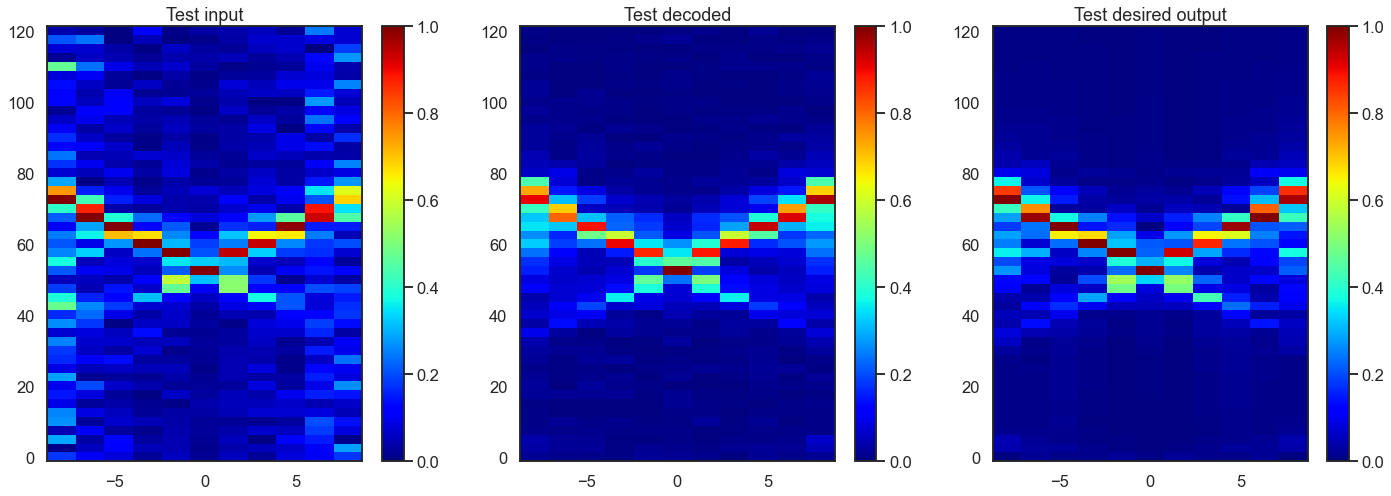

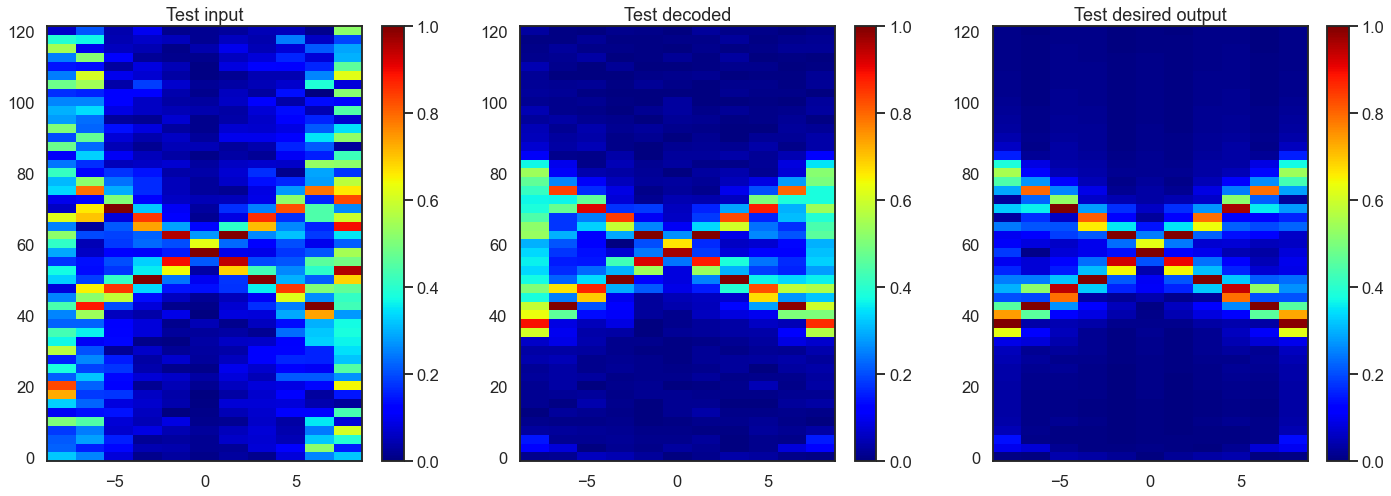

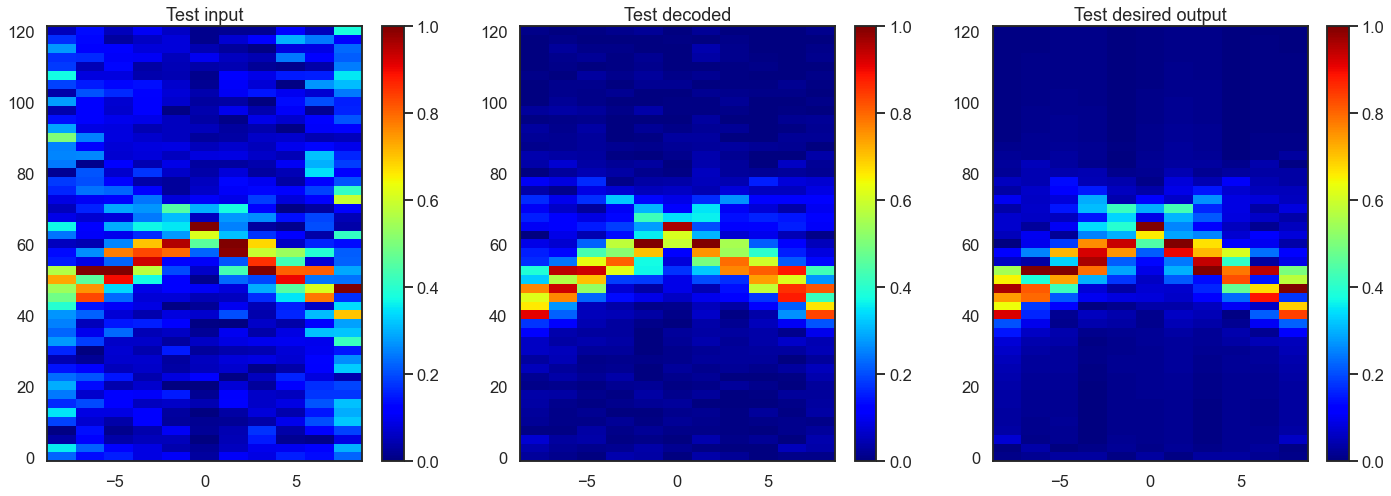

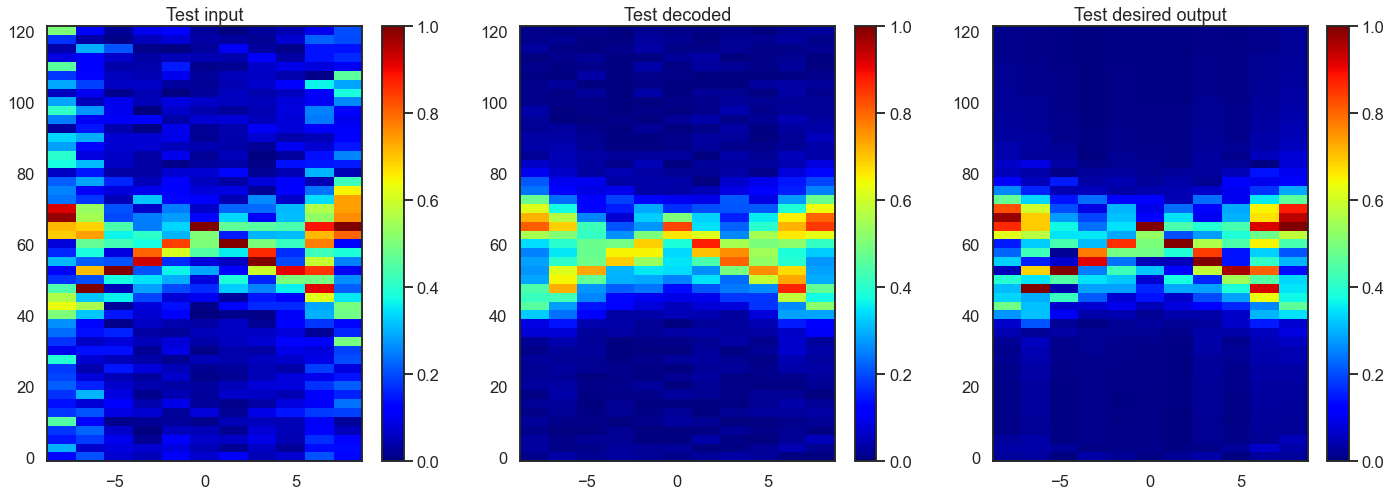

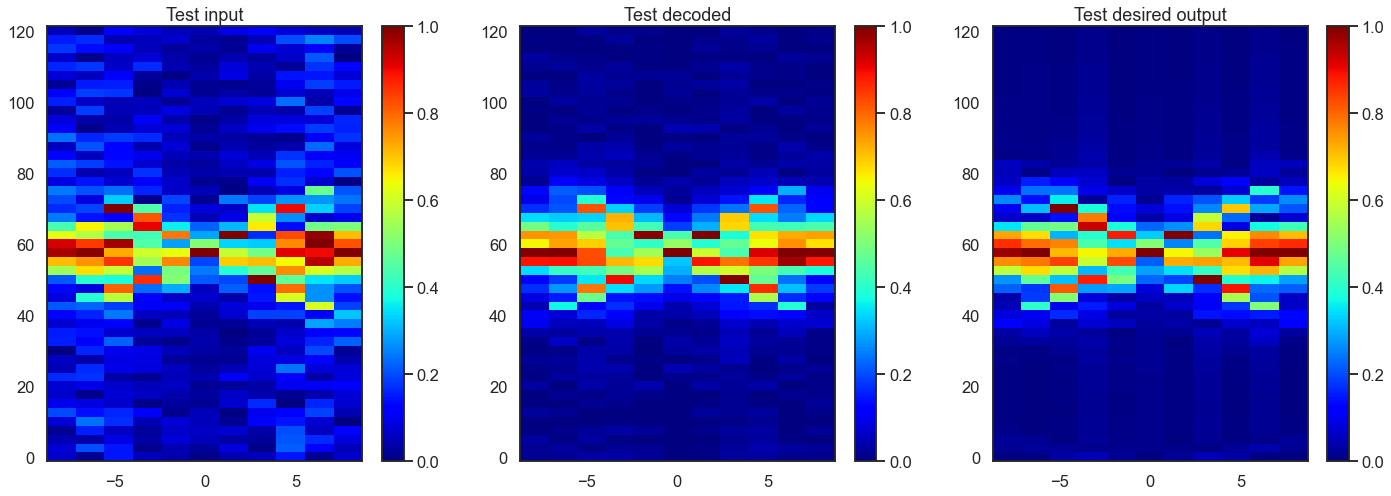

In [82]:
#sampleno = 3
for sampleno in range(0,13):
  plt.figure(figsize=(24,8))

  plt.subplot(1, 3, 1)
  plt.pcolormesh(x_array, f_array/1e3, x_test_fk[sampleno, 0,:, :], cmap='jet', vmin=0, vmax=1)
  #plt.grid()
  plt.colorbar()
  plt.title('Test input')

  plt.subplot(1, 3, 2)
  plt.pcolormesh(x_array, f_array/1e3, decoded_shaped_fk[sampleno, 0,:, :], cmap='jet', vmin=0, vmax=1)
  #plt.grid()
  plt.colorbar()
  plt.title('Test decoded')

  plt.subplot(1, 3, 3)
  plt.pcolormesh(x_array, f_array/1e3, y_test_fk[sampleno, 0,:, :], cmap='jet', vmin=0, vmax=1)
  #plt.grid()
  plt.colorbar()
  plt.title('Test desired output')


  plt.savefig('./images/simulations_autoencoder_' + str(sampleno).zfill(2) + '.png')
  plt.show()

In [83]:
measurements_mod = measurements.swapaxes(1,2)


In [84]:
measurements_mod = np.expand_dims(measurements_mod, 1)

In [85]:
measurements_mod.shape, X_sample_n.shape

((41, 1, 11, 400), (1250, 1, 11, 400))

In [86]:
measurements_fk, x_array, f_array = make_fk_samples(measurements_mod, dt, dx, returndb=False)

(41, 1, 2, 400, 11)


In [87]:
if amp_only:
  measurements_fk = measurements_fk[:,:,0,:,:]

In [88]:
measurements_flat_fk = measurements_fk.reshape((len(measurements_fk), np.prod(measurements_fk.shape[1:])))

In [89]:
measurements_flat_fk.shape

(41, 539)

In [90]:
decoded_measurements_fk = autoencoder_fk.predict(measurements_flat_fk)

2/2 [==============================] - 0s 4ms/step


In [91]:
encoded_measurements_fk = encoder_fk.predict(measurements_flat_fk)

2/2 [==============================] - 0s 3ms/step


In [92]:
decoded_measurements_shaped_fk = decoded_measurements_fk.reshape(len(decoded_measurements_fk), measurements_fk.shape[1], measurements_fk.shape[2], measurements_fk.shape[3])

In [93]:
decoded_measurements_shaped_fk.shape

(41, 1, 49, 11)

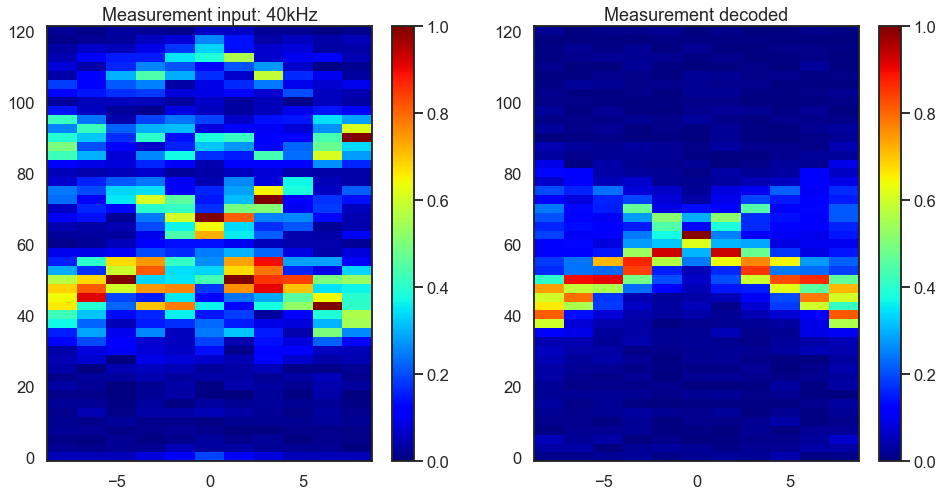

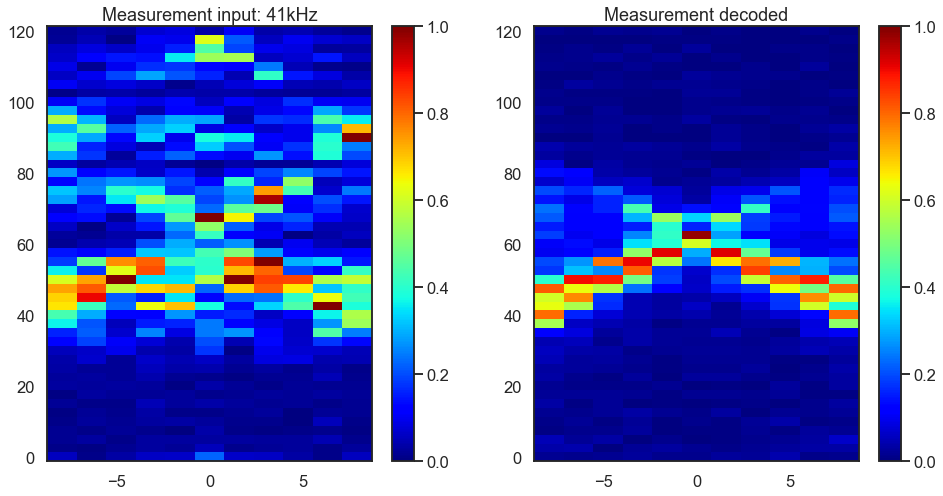

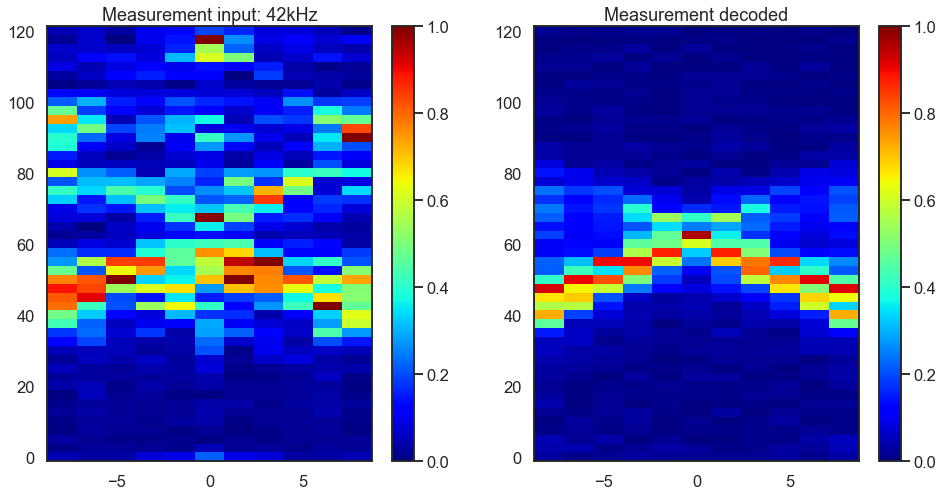

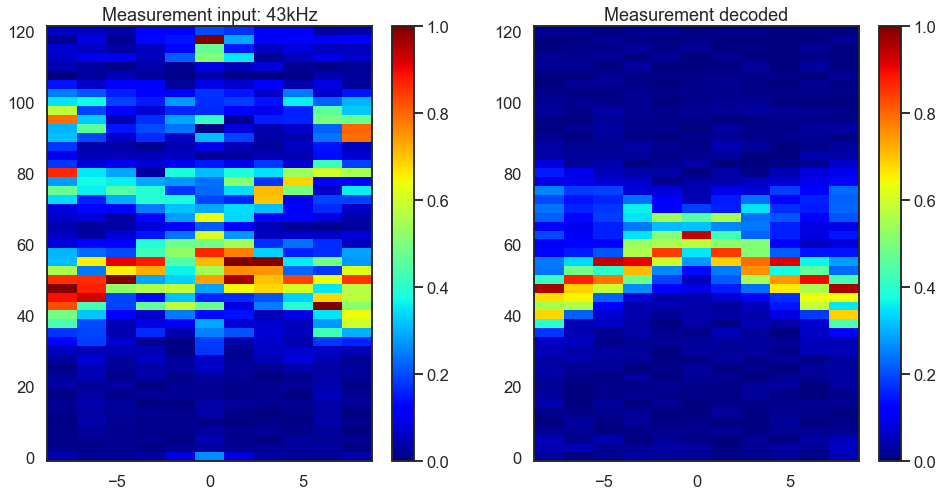

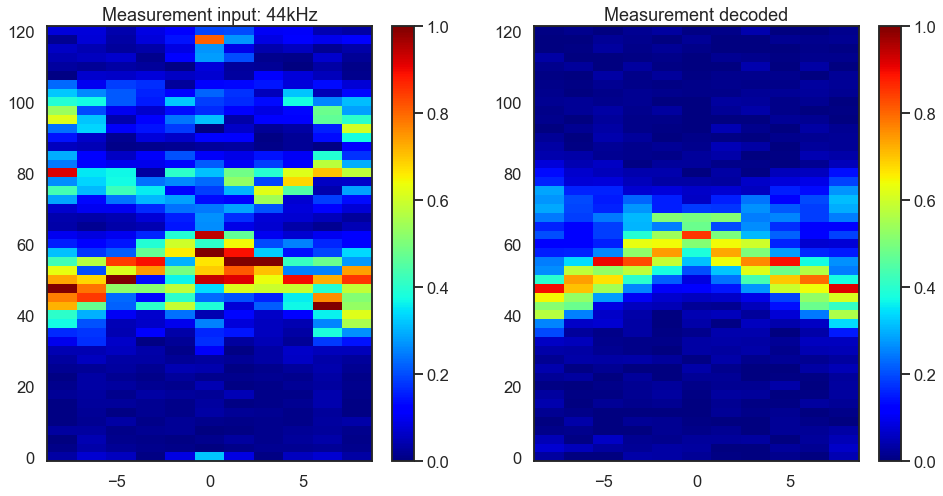

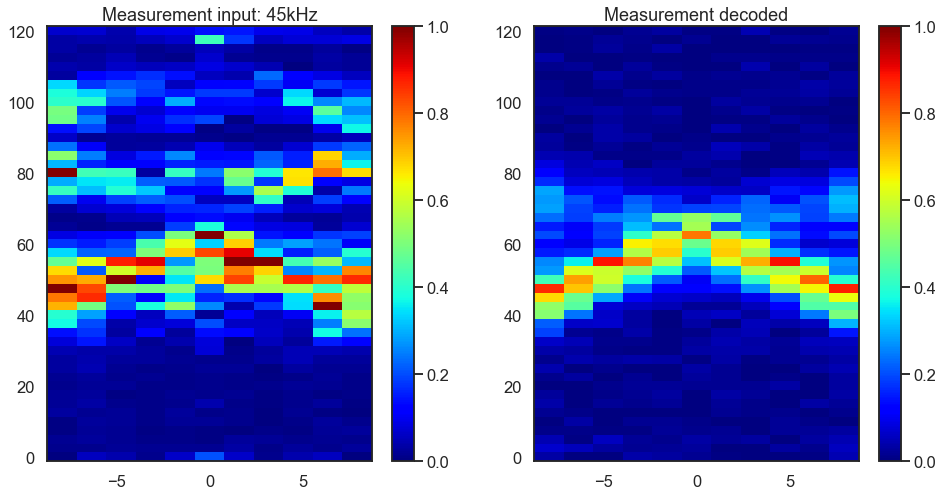

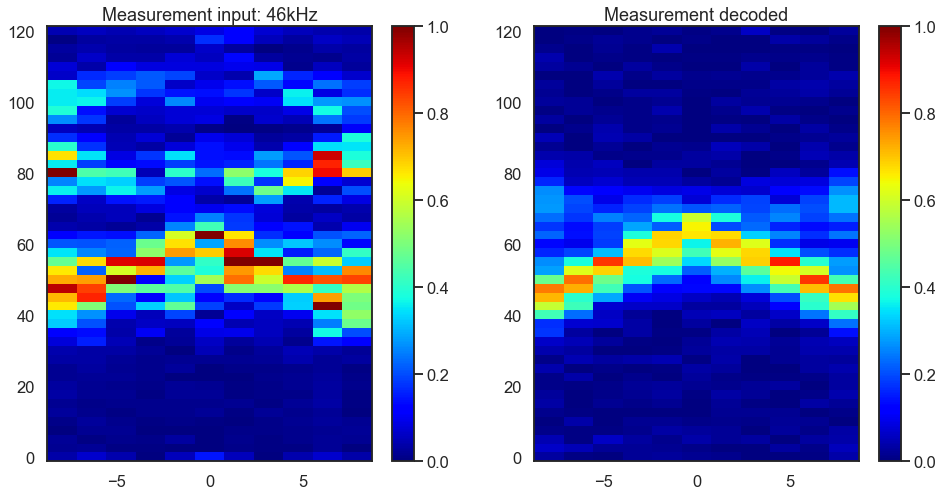

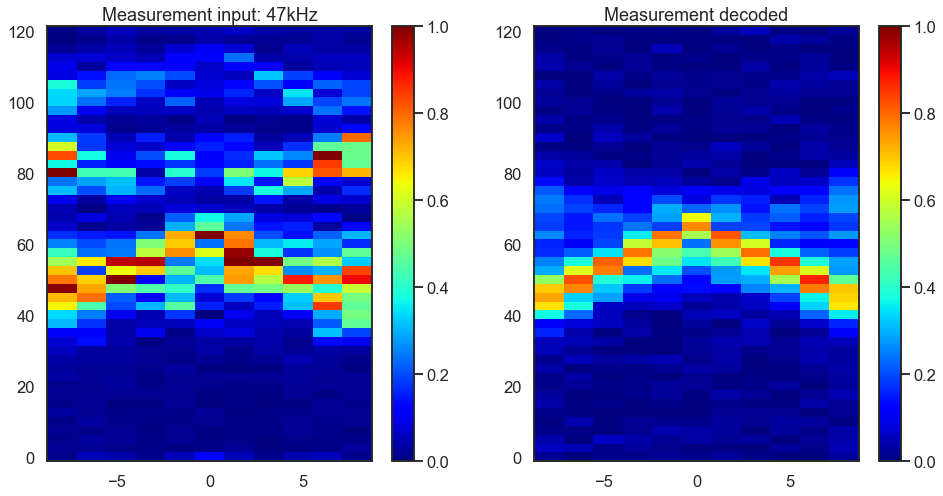

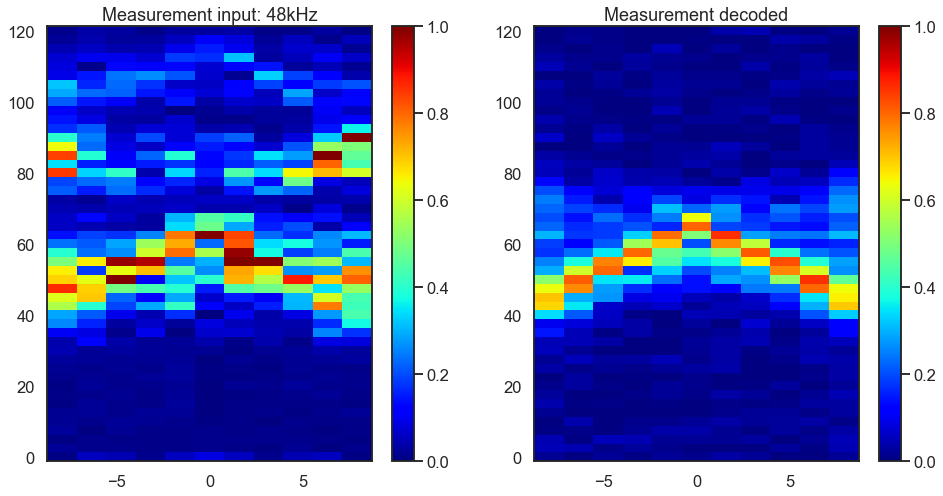

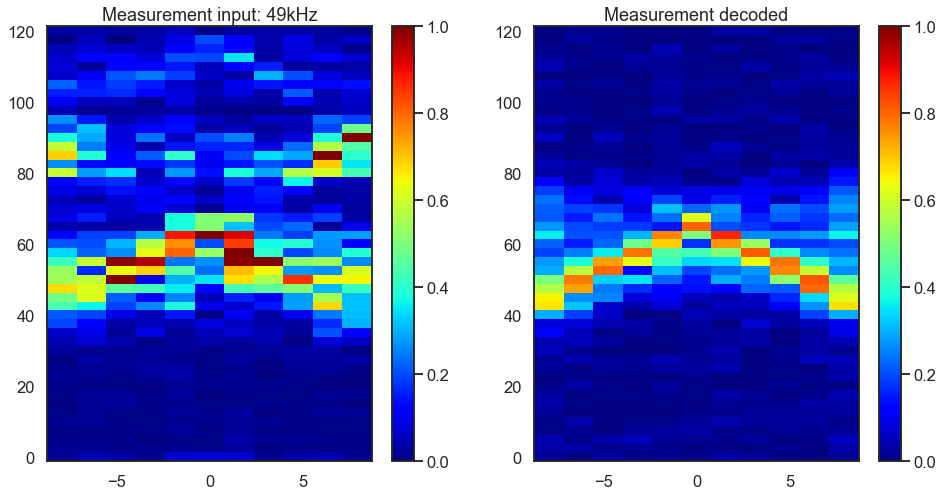

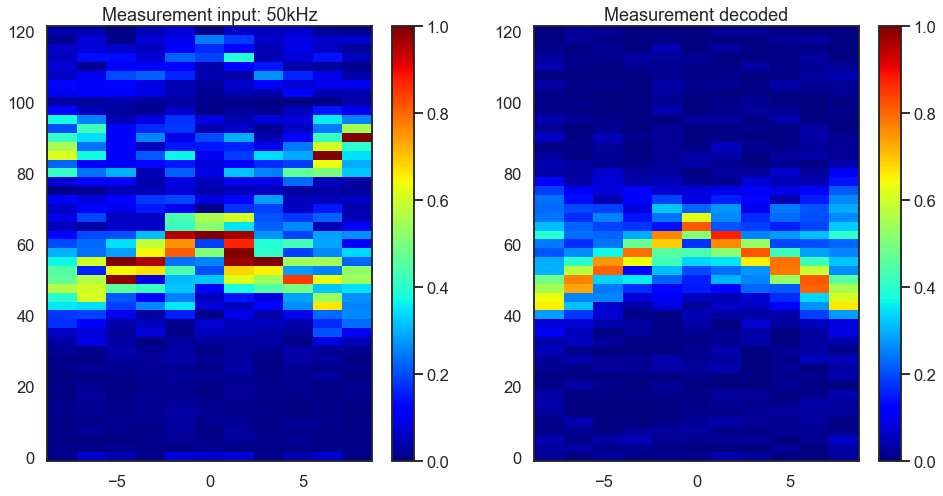

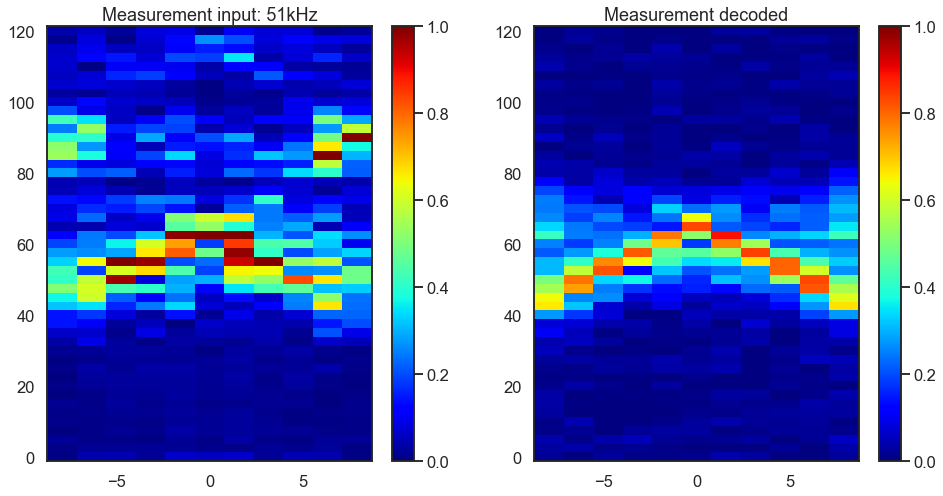

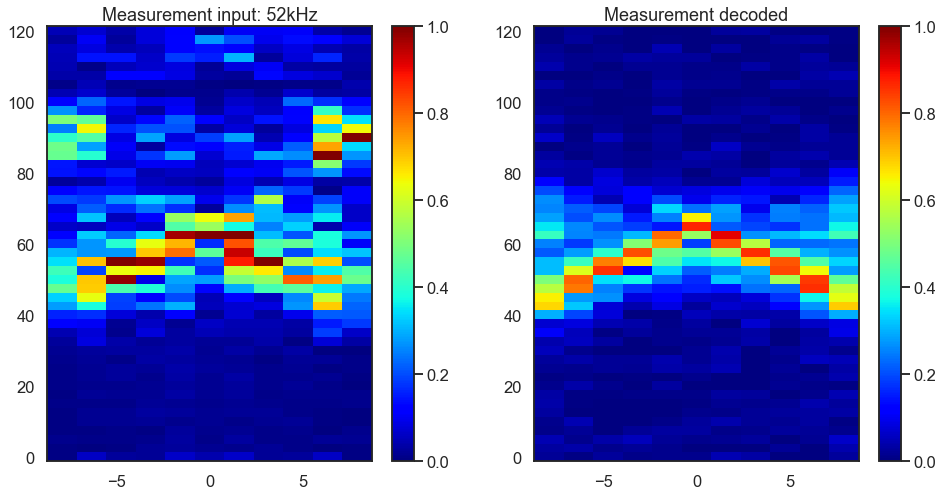

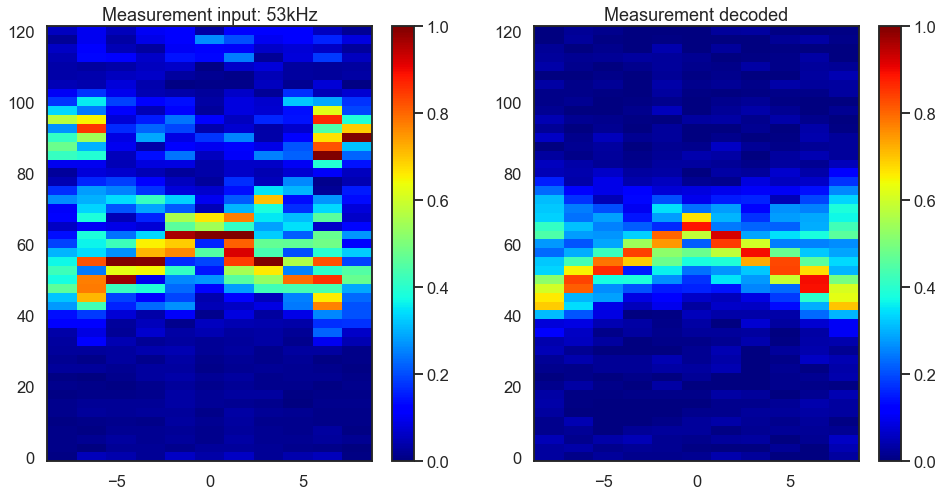

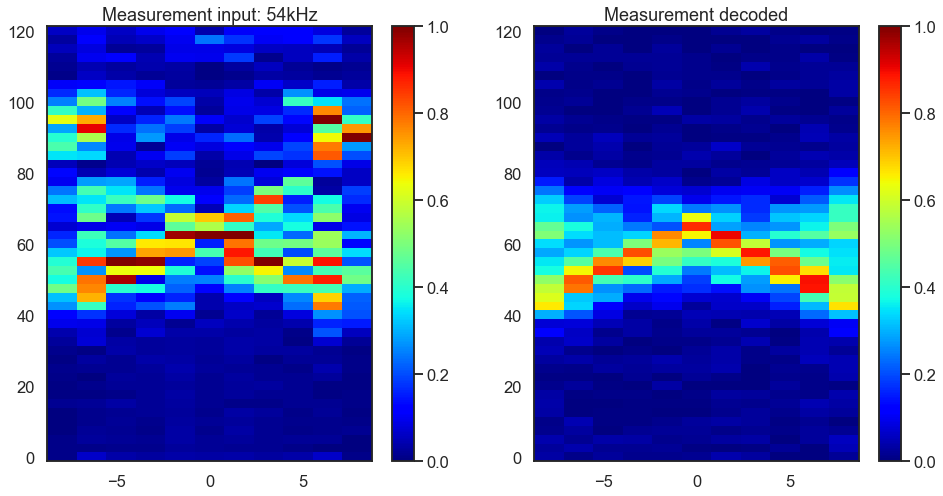

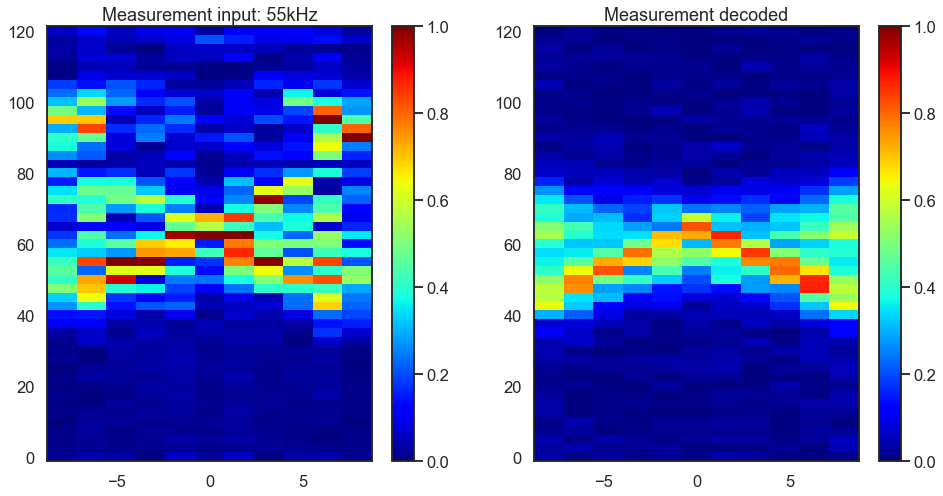

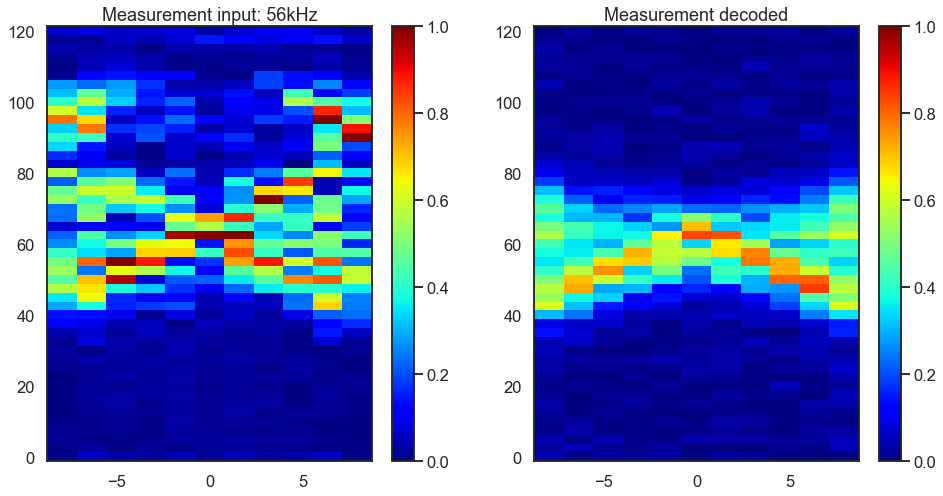

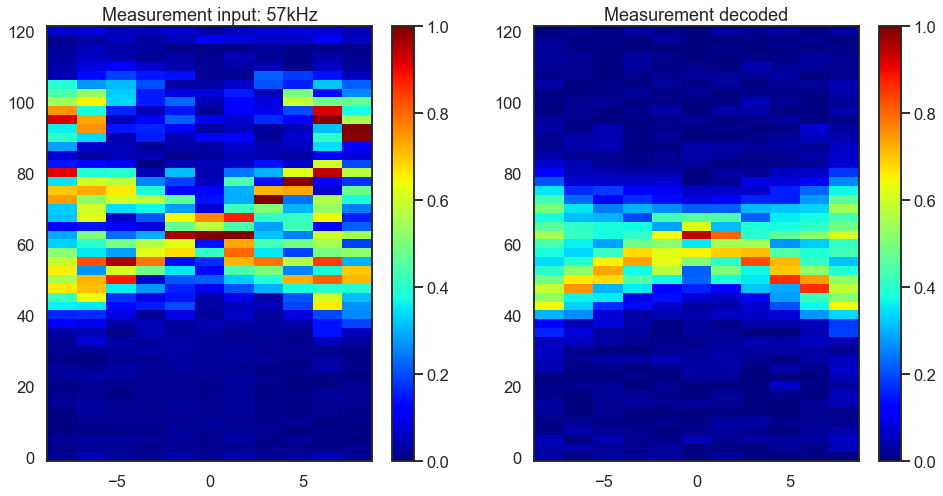

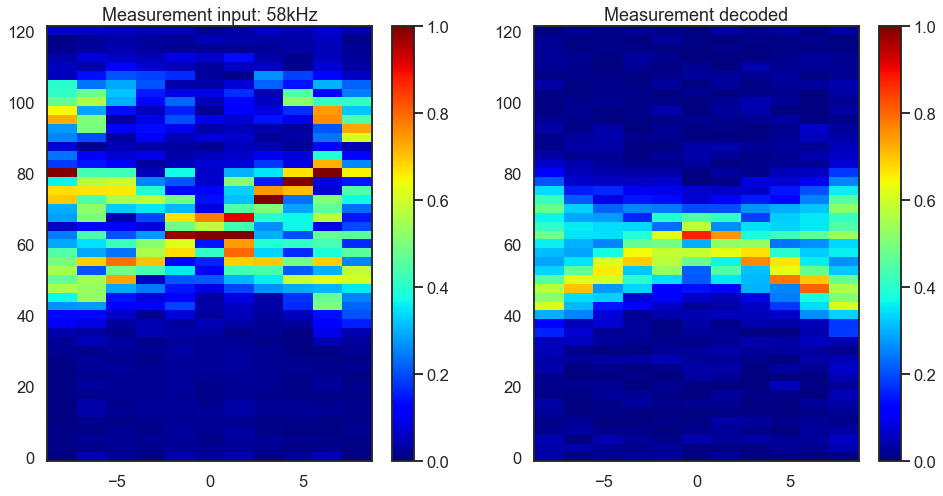

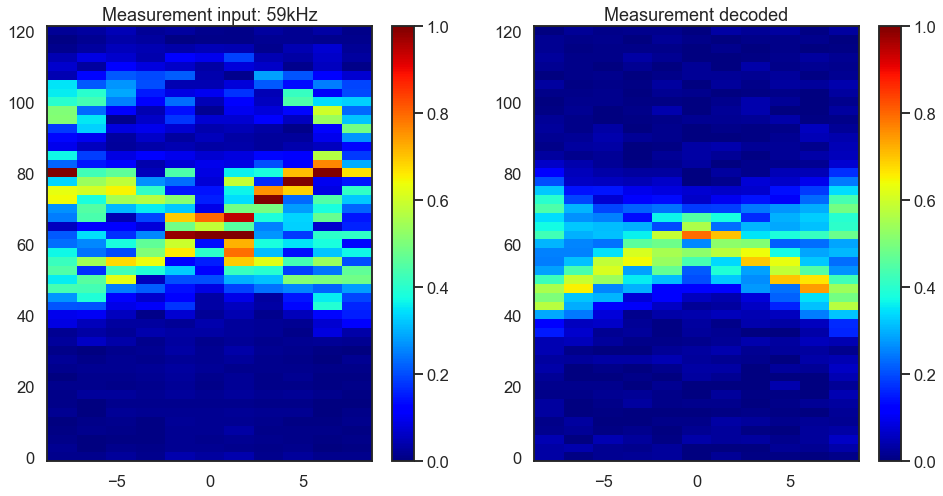

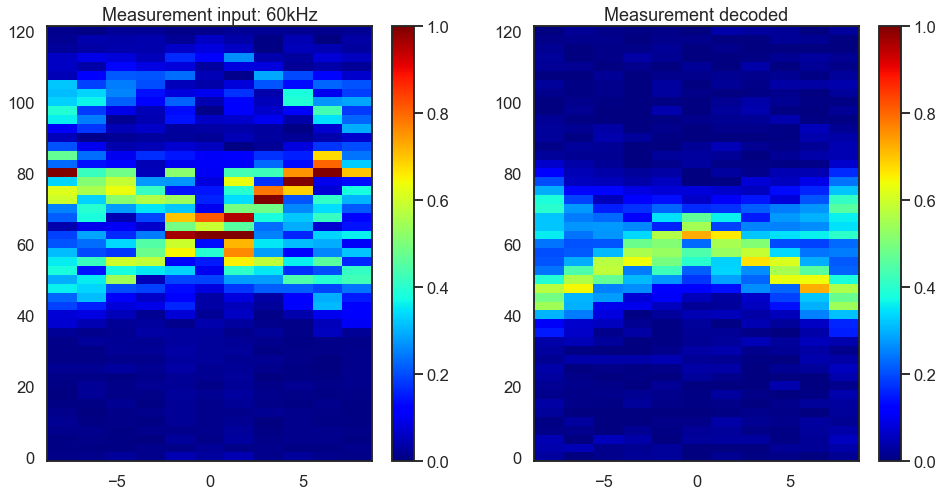

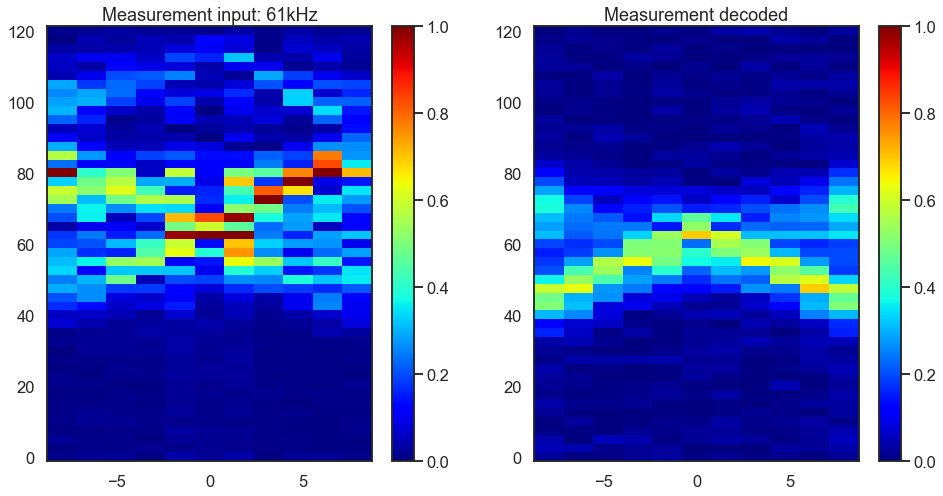

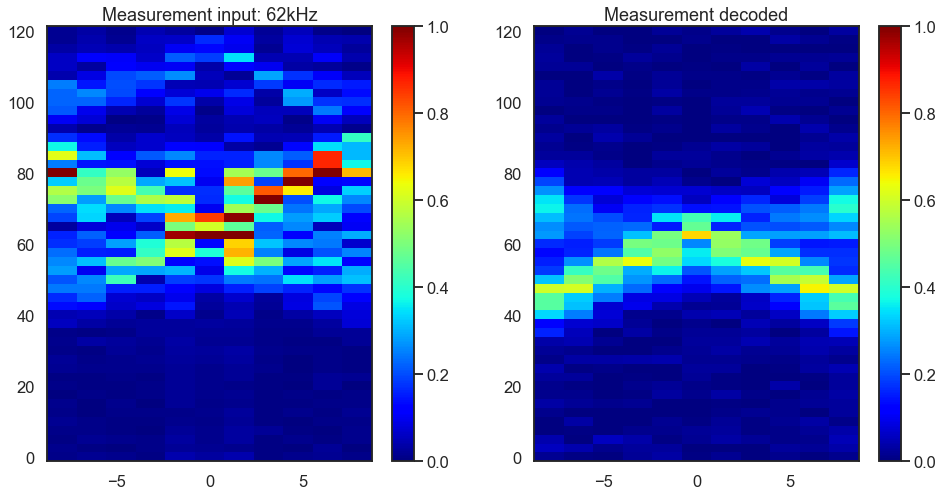

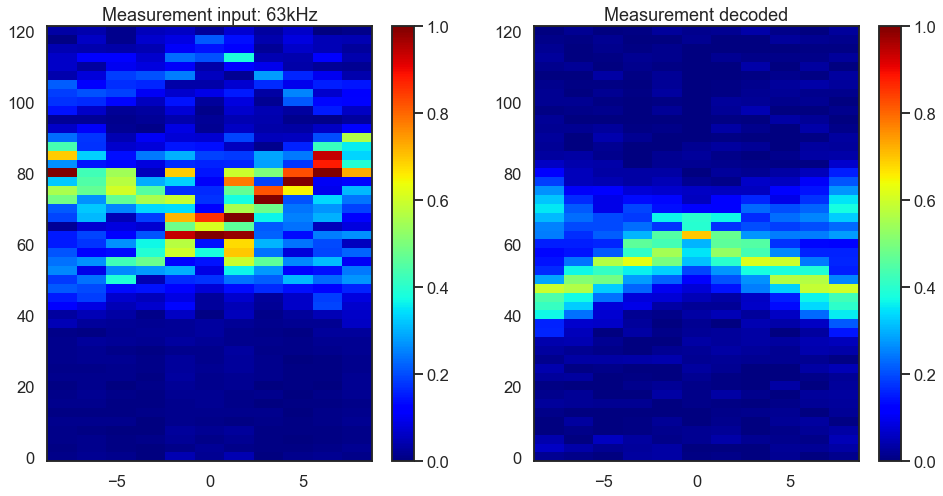

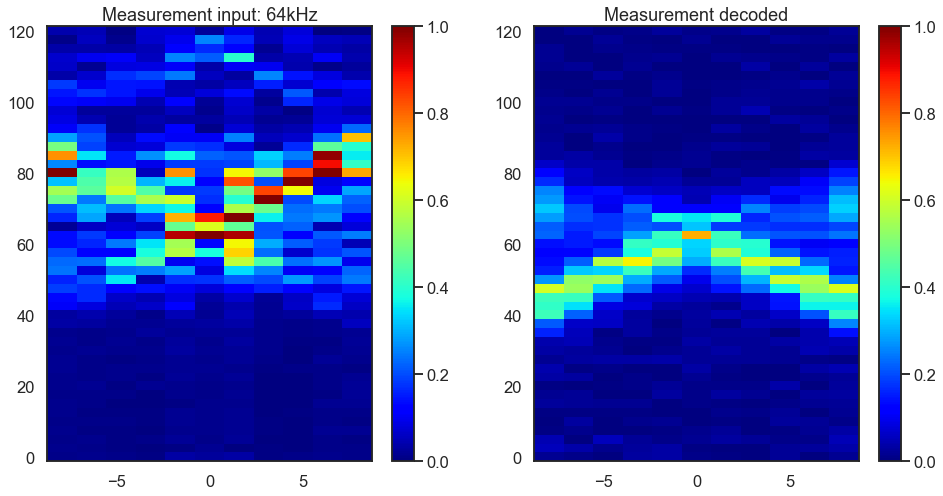

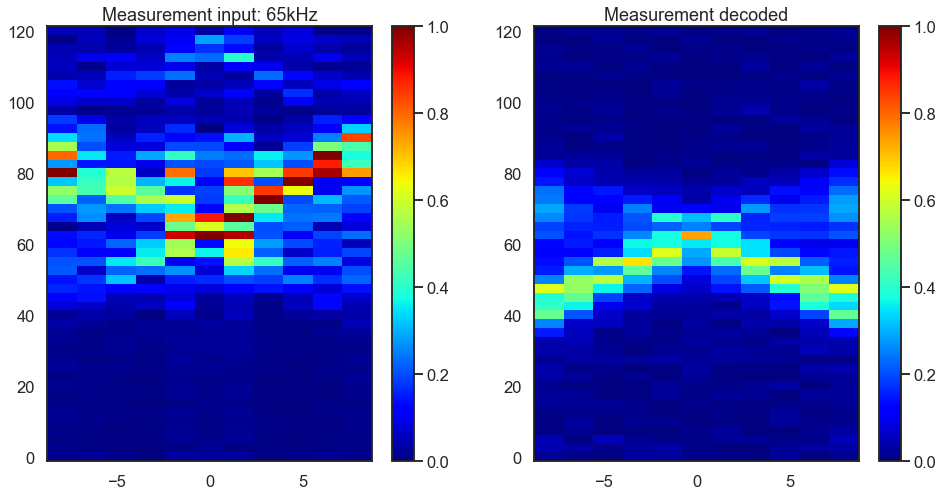

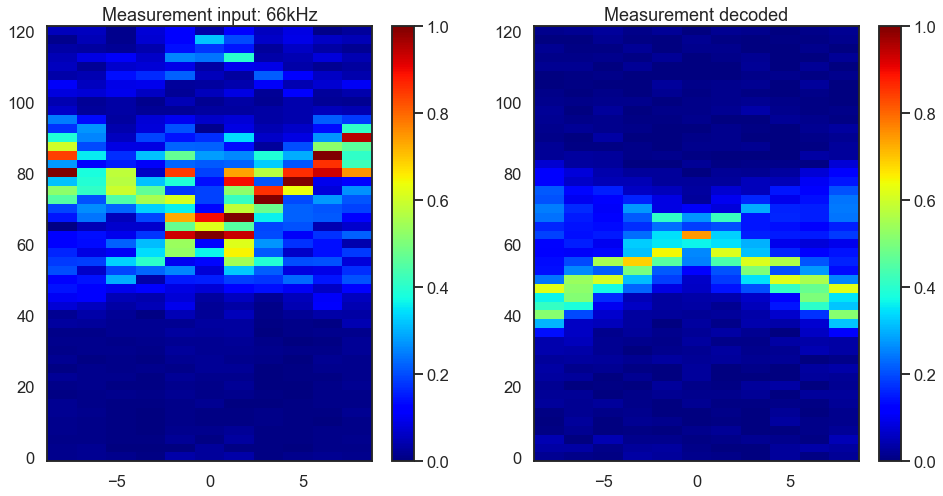

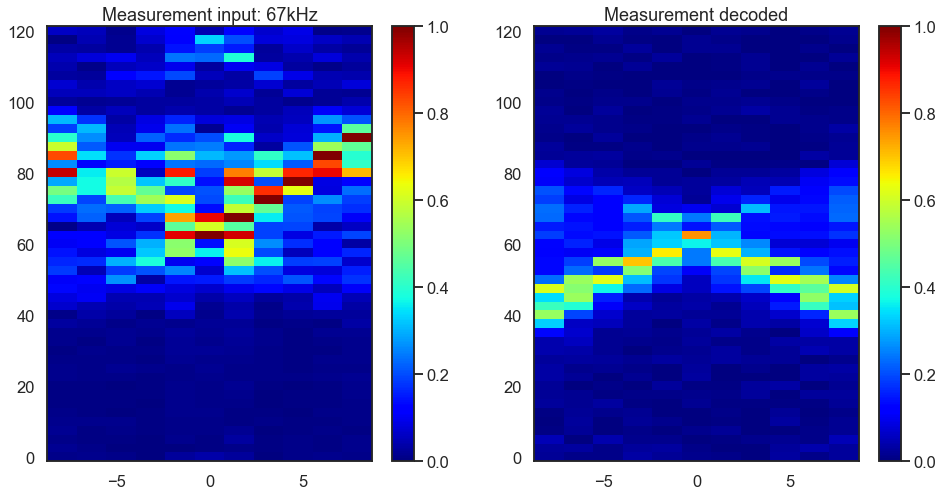

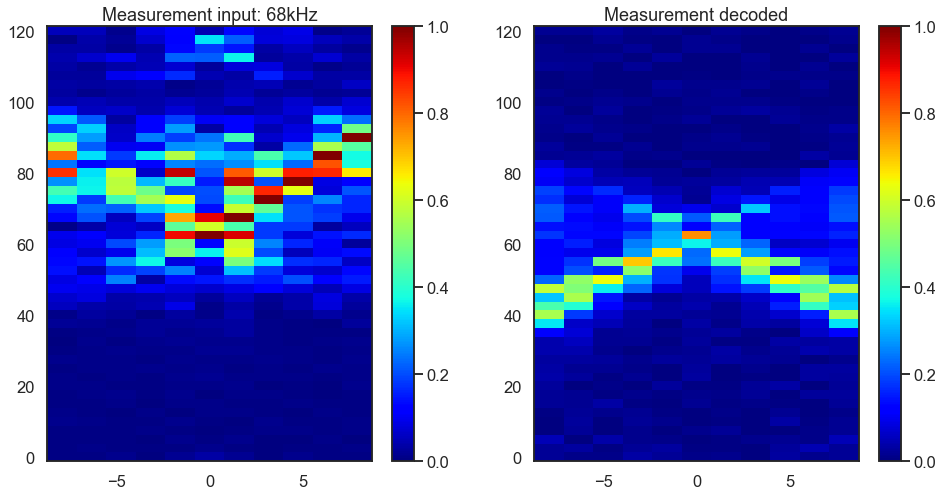

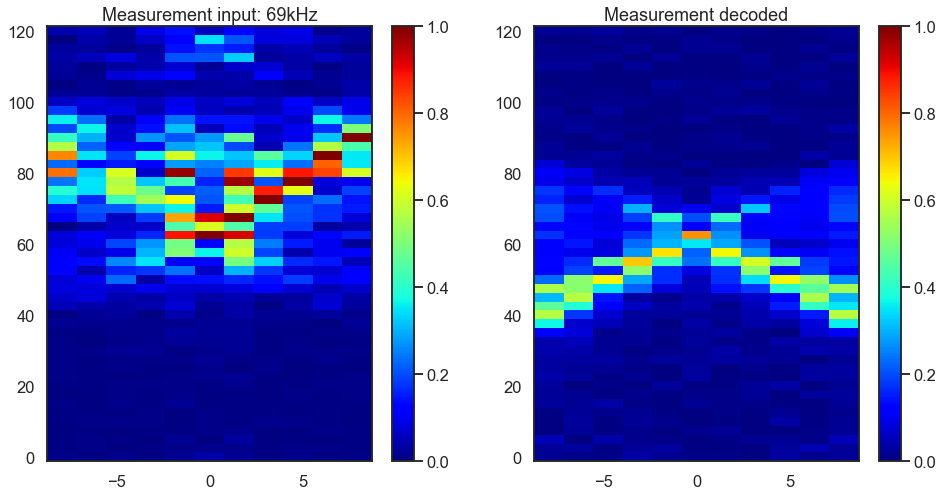

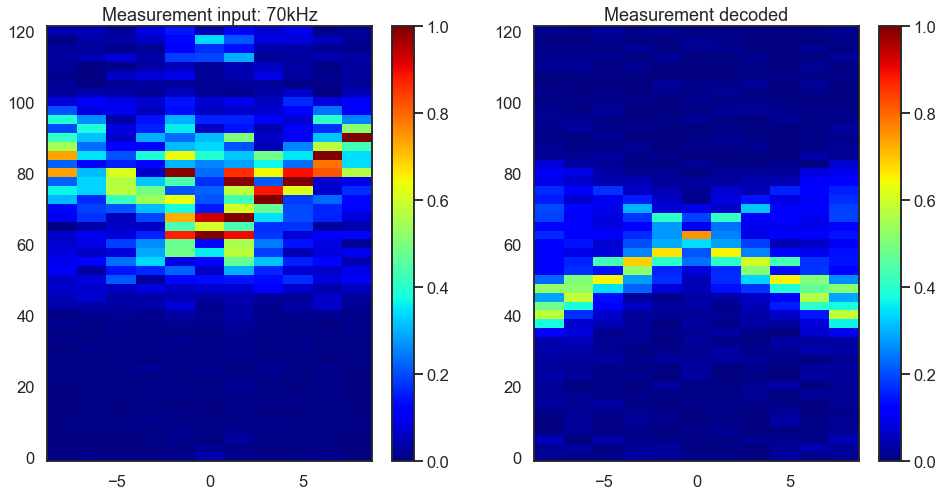

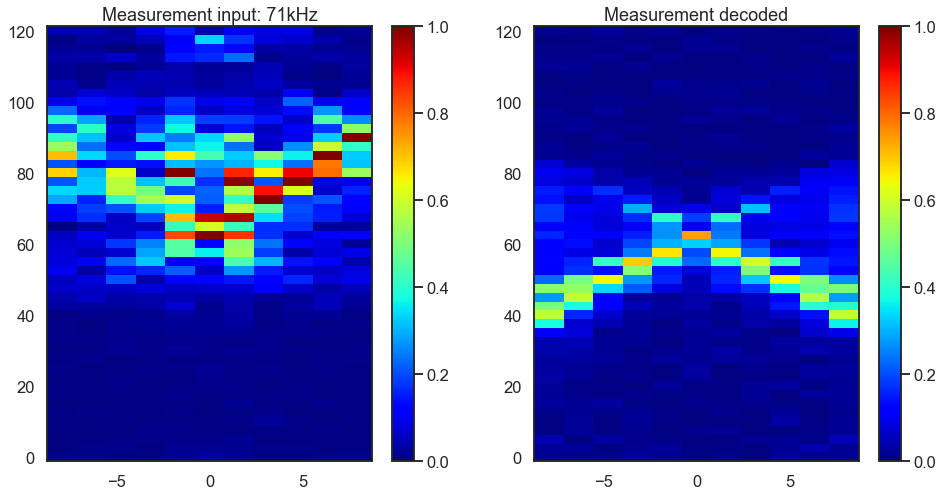

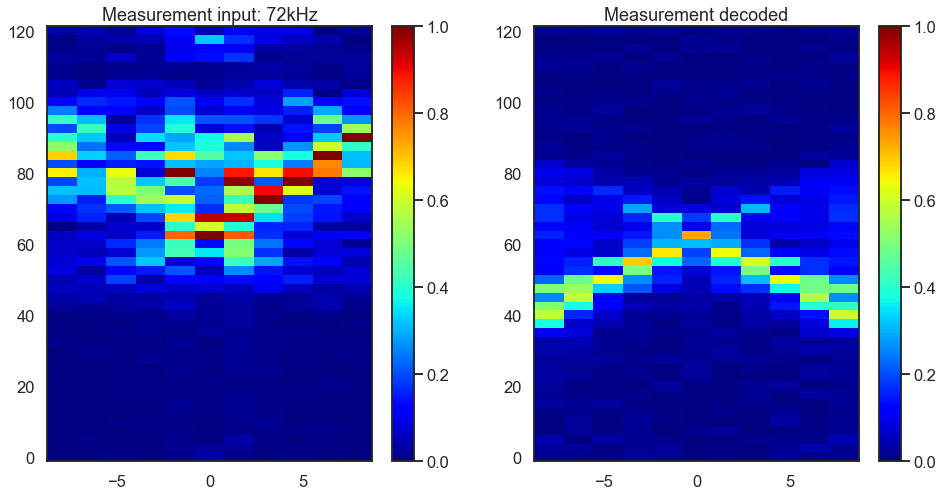

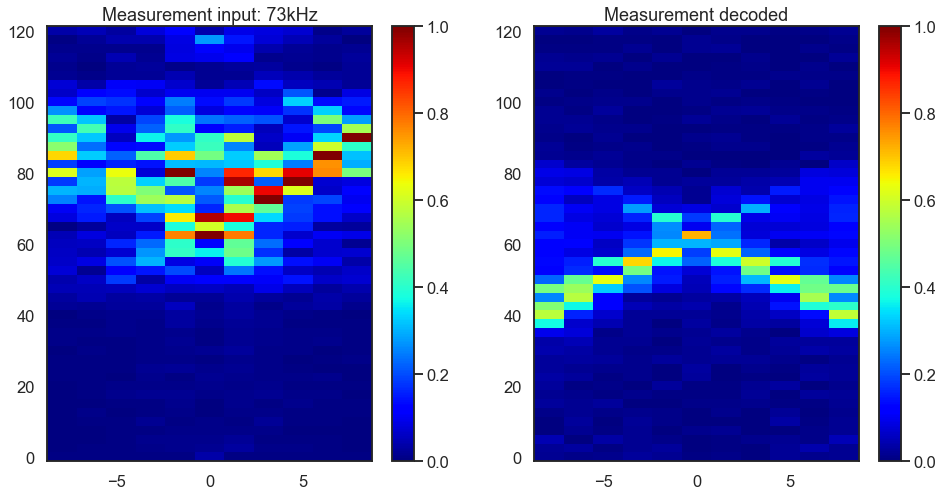

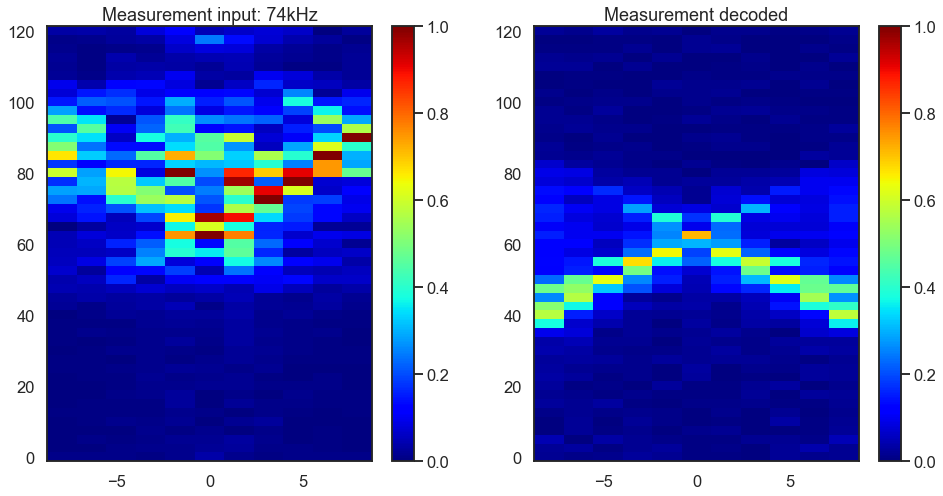

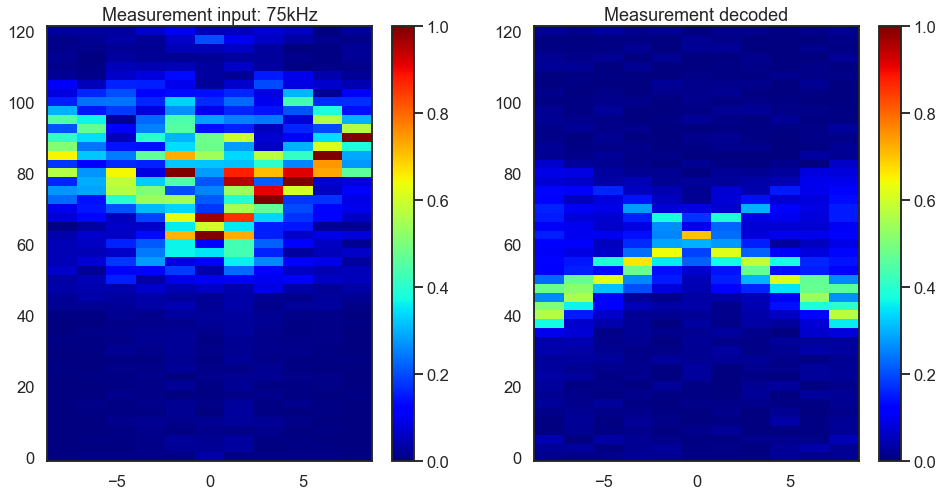

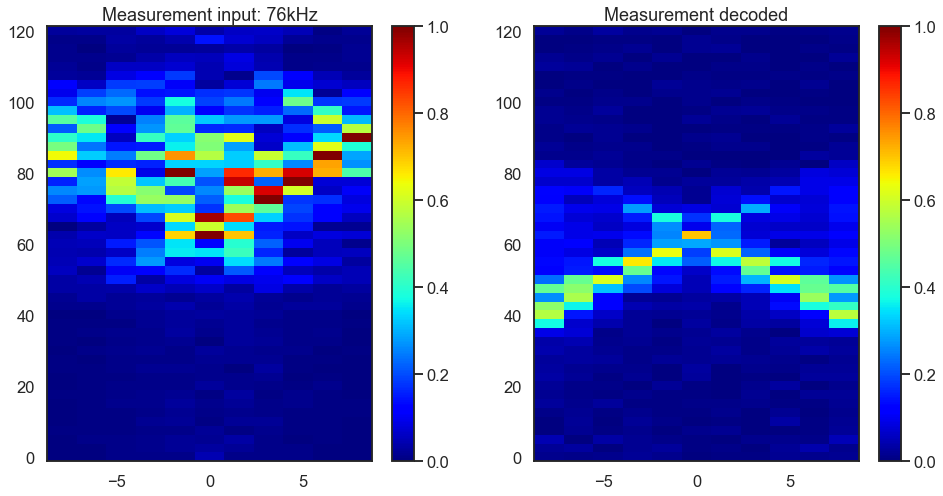

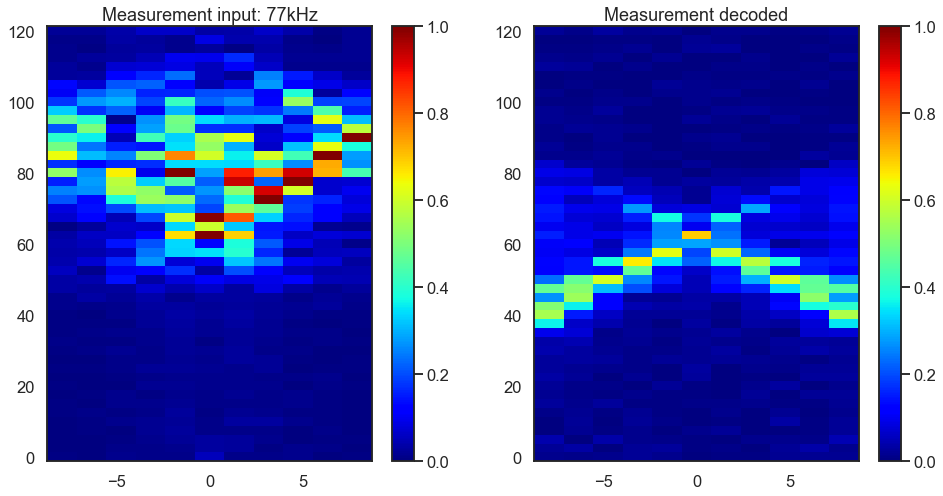

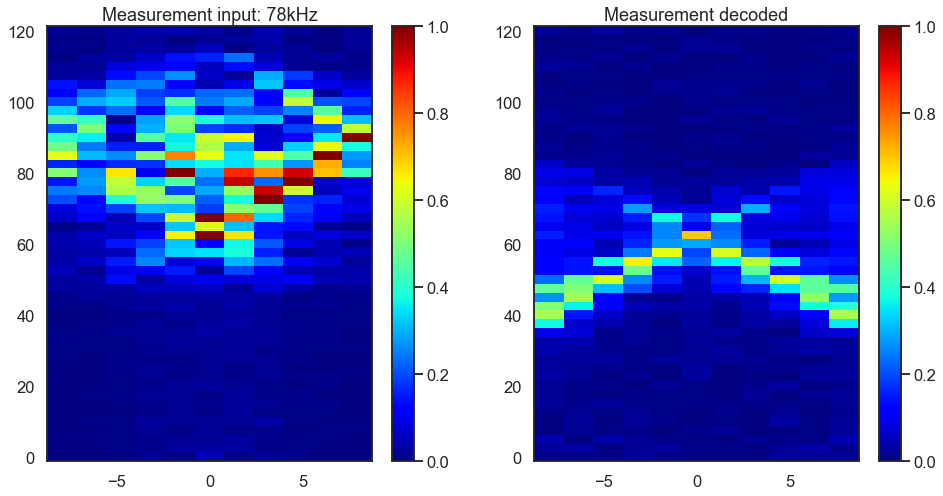

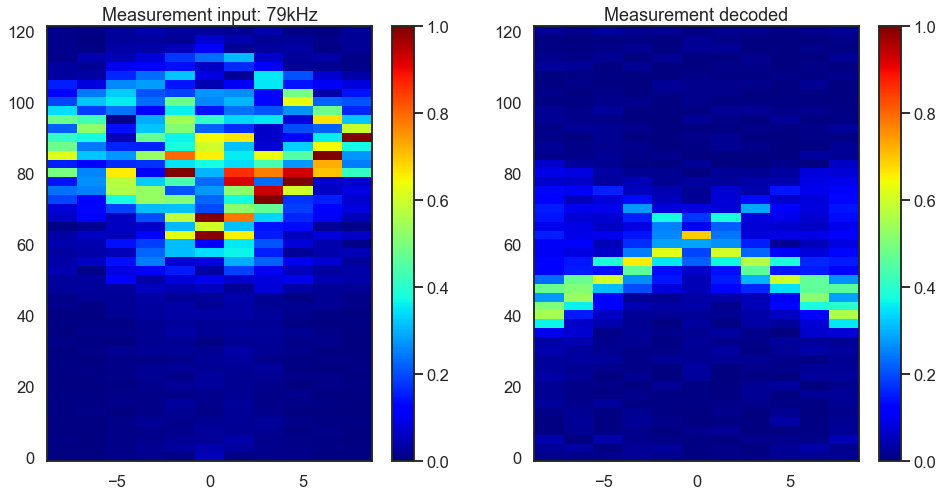

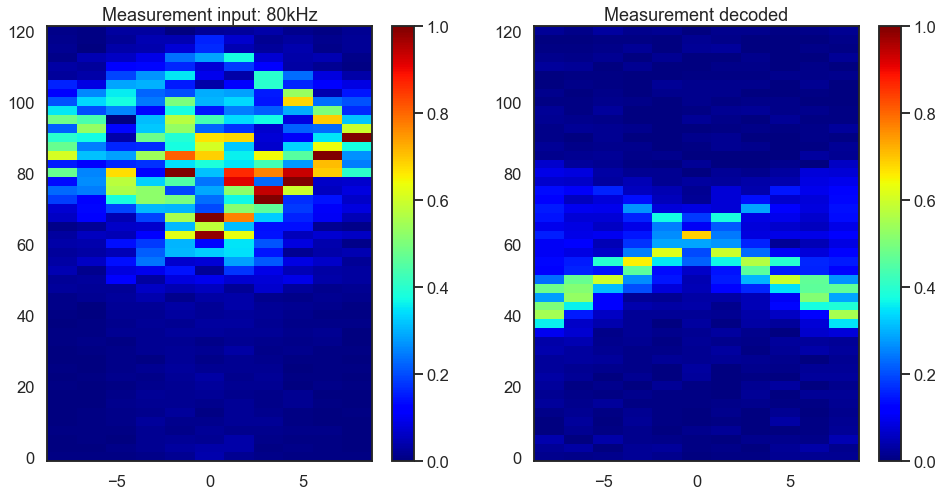

In [94]:
for testno in range(0,41):
  plt.figure(figsize=(16,8))

  plt.subplot(1, 2, 1)
  plt.pcolormesh(x_array, f_array/1e3, measurements_fk[testno, 0,:, :], cmap='jet', vmin=0, vmax=1)
  #plt.grid()
  plt.colorbar()
  plt.title('Measurement input: '+ str(testno+40) + 'kHz')

  plt.subplot(1, 2, 2)
  plt.pcolormesh(x_array, f_array/1e3, decoded_measurements_shaped_fk[testno, 0,:, :], cmap='jet', vmin=0, vmax=1)
  #plt.grid()
  plt.colorbar()
  plt.title('Measurement decoded')

  #plt.subplot(1, 3, 3)
  #plt.pcolormesh(x_array, f_array/1e3, decoded_measurements_shaped_fk[20, 0,:, :], cmap='jet', vmin=0, vmax=1)
  #plt.grid()
  #plt.colorbar()
  #plt.title('Test desired output')

  plt.savefig('./images/measurements_encoded_' +str(testno).zfill(2) + '.png')
  plt.show()

In [95]:
X_sample_flat_fk = X_sample_n_fk.reshape((len(X_sample_n_fk), np.prod(X_sample_n_fk.shape[1:])))
X_sample_flat_fk.shape

(1250, 539)

In [96]:
encoded_all_fk = encoder_fk.predict(X_sample_flat_fk)

40/40 [==============================] - 0s 2ms/step


Thickness mean


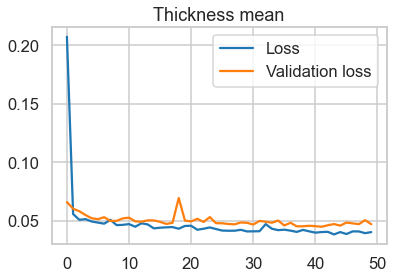

8/8 [==============================] - 0s 2ms/step - loss: 0.0471
loss: 0.047136638313531876
Thickness minimum


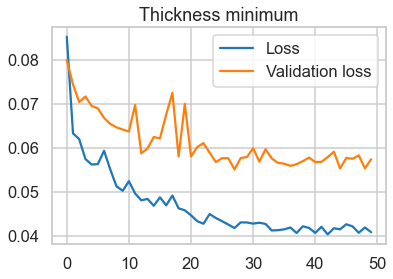

8/8 [==============================] - 0s 2ms/step - loss: 0.0574
loss: 0.05735527724027634
Thickness std


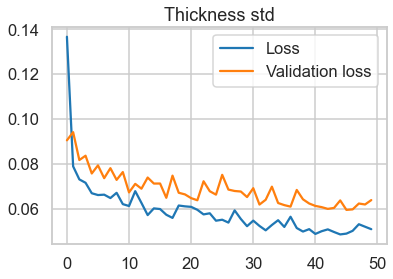

8/8 [==============================] - 0s 1ms/step - loss: 0.0638
loss: 0.06381278485059738
Depression depth


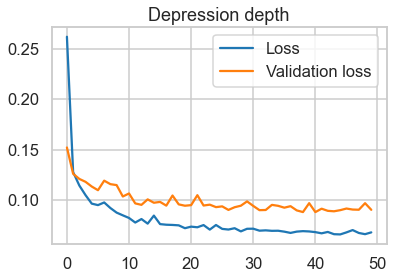

8/8 [==============================] - 0s 2ms/step - loss: 0.0902
loss: 0.09020263701677322
Depression width


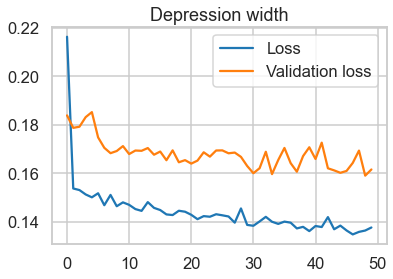

8/8 [==============================] - 0s 2ms/step - loss: 0.1616
loss: 0.16162508726119995
Pitting depth


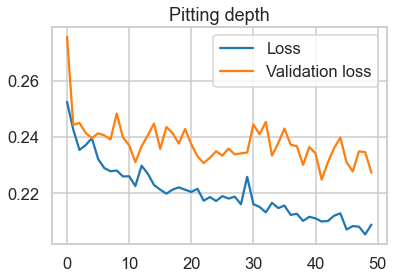

8/8 [==============================] - 0s 2ms/step - loss: 0.2273
loss: 0.22729715704917908


In [97]:
sns.set_style('whitegrid')
df_loss = pd.DataFrame(columns=attributes)
df_test = pd.DataFrame(columns=attributes)
df_predict = pd.DataFrame(columns=attributes)
regression_models = {}
min_max_scalers = {}
for attribute in attributes:
  print(attribute)
  y_reg = label_sample[[attribute]]

  min_max_scaler = MinMaxScaler()
  y_reg = min_max_scaler.fit_transform(y_reg)
  x_reg_train, x_reg_test, y_reg_train, y_reg_test_norm = train_test_split(encoded_all_fk, y_reg, test_size=0.2, random_state=42)
  regression_model = make_regression_model()
  regression_model.compile(loss='mae', optimizer='adam')
  history = regression_model.fit(x_reg_train, y_reg_train.astype('float32'),
                epochs=50,
                batch_size=20,
                shuffle=True,
                verbose=0,
                validation_data=(x_reg_test, y_reg_test_norm.astype('float32')))

  plt.figure(figsize=(6, 4))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['Loss', 'Validation loss'])
  plt.title(attribute)
  plt.show()

  y_predict_norm = regression_model.predict(x_reg_test)
  y_predict = min_max_scaler.inverse_transform(y_predict_norm)
  y_reg_test = min_max_scaler.inverse_transform(y_reg_test_norm)
  loss = regression_model.evaluate(x_reg_test, y_reg_test_norm)
  print("loss: " + str(loss))
  df_loss.at[0, attribute] = loss
  df_test[attribute] = np.squeeze(y_reg_test)
  df_predict[attribute] = np.squeeze(y_predict)
  regression_models[attribute] = regression_model
  min_max_scalers[attribute] = min_max_scaler

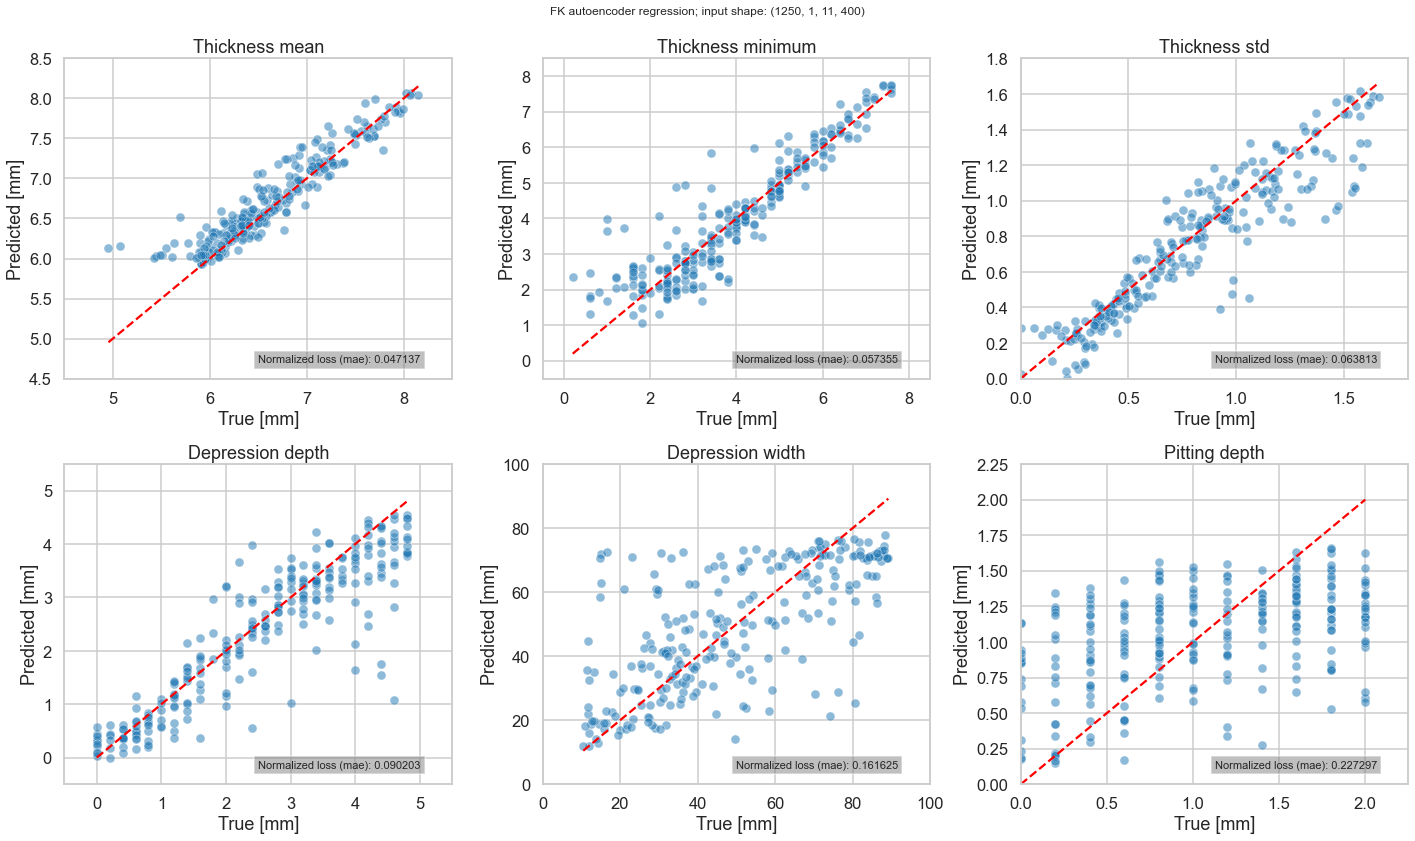

In [98]:
plot_reg_results(df_test, df_predict, df_loss, df_scales, perc=False, title='FK autoencoder regression; input shape: '+ str(X_sample_n.shape))

In [99]:
df_test.columns

Index(['Thickness mean', 'Thickness minimum', 'Thickness std',
       'Depression depth', 'Depression width', 'Pitting depth'],
      dtype='object')

In [100]:
df_scales['Thickness mean'][0]

4.5

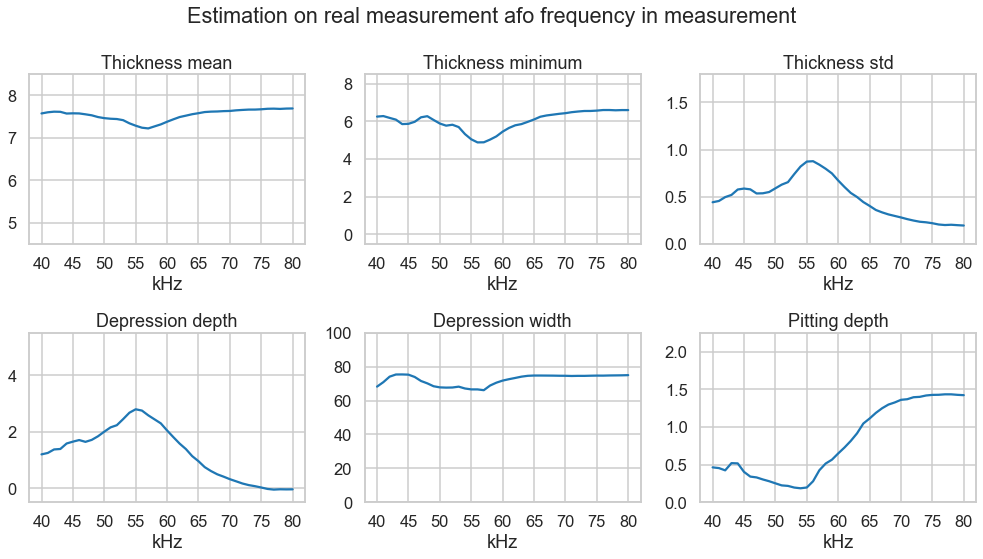

In [101]:
sns.set_context('talk')
sns.set_style('whitegrid')
real_prediction = {}
plt.figure(figsize=(14, 8))
for i, attribute in enumerate(attributes):
  real_prediction_norm = regression_models[attribute](encoded_measurements_fk)

  real_prediction[attribute] = min_max_scalers[attribute].inverse_transform(real_prediction_norm)
  plt.subplot(2,3, i+1)
  plt.plot(real_prediction[attribute])
  plt.ylim([df_scales[attribute][0], df_scales[attribute][1]])
  plt.title(attribute)
  plt.xticks(range(0, 41, 5), range(40, 81, 5))
  plt.xlabel('kHz')
plt.suptitle('Estimation on real measurement afo frequency in measurement')
plt.tight_layout()
plt.show()

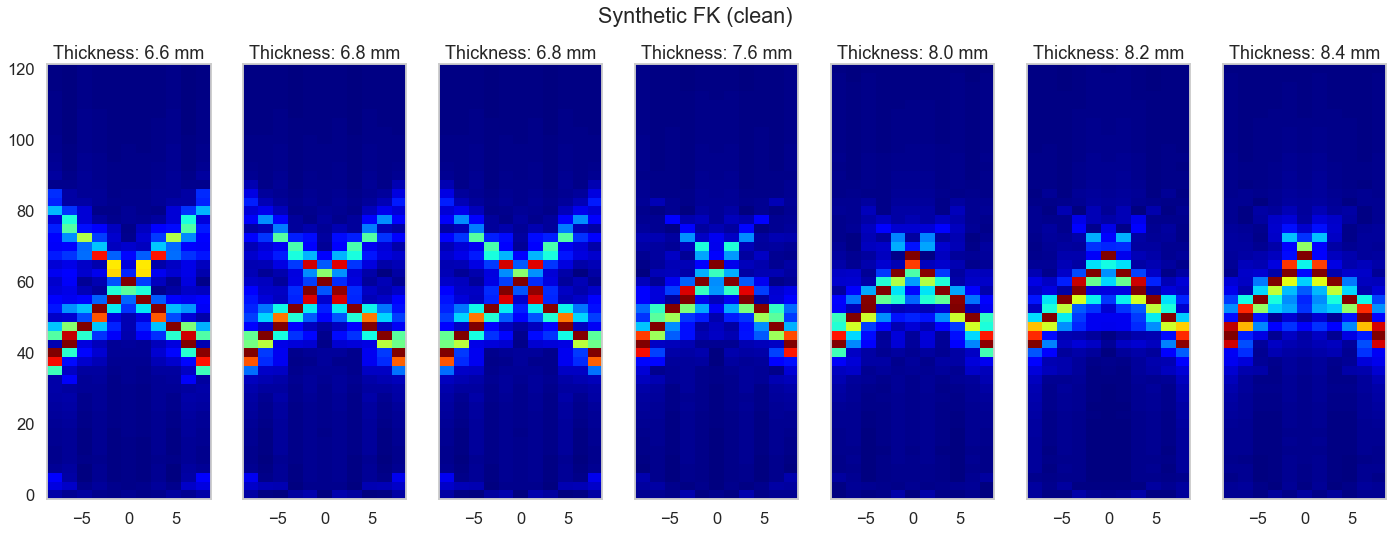

In [102]:
plt.figure(figsize=(24,8))
for i, case in enumerate(cases_ideal):
  plt.subplot(1, len(cases_ideal), i+1)
  plt.pcolormesh(x_array, f_array/1e3, X_sample_c_fk[case, 0,:, :], cmap='jet', vmin=0, vmax=1)
  if i>0:
    plt.yticks([])
  plt.title('Thickness: ' + str(labels.iloc[case]['Thickness mean']) + ' mm')
plt.suptitle('Synthetic FK (clean)')
plt.show()

In [103]:
labels.iloc[case]['Thickness mean']

8.4

In [104]:
X_sample_n_fk.shape

(1250, 1, 49, 11)

In [105]:
real_prediction['Thickness mean'][20].item()

7.378900822058874

In [110]:
freqno = 20
limit = 0.2
labels[(labels['Thickness mean'] >= real_prediction['Thickness mean'][freqno].item() - limit  ) & (labels['Thickness mean'] <= real_prediction['Thickness mean'][freqno].item() + limit) &
       (labels['Thickness minimum'] >= real_prediction['Thickness minimum'][freqno].item() - limit) & (labels['Thickness minimum'] <= real_prediction['Thickness minimum'][freqno].item() +limit) &
       (labels['Depression depth'] >= real_prediction['Depression depth'][freqno].item() - limit) & (labels['Depression depth'] <= real_prediction['Depression depth'][freqno].item() + limit) &
       (labels['Pitting depth'] >= real_prediction['Pitting depth'][freqno].item() - limit) & (labels['Pitting depth'] <= real_prediction['Pitting depth'][freqno].item() + limit)]

modelname  Thickness        seed  \
932   model_c3456_t040_d010_p003_s1875757455        8.0  1875757455   
933   model_c3456_t040_d010_p003_s1941405600        8.0  1941405600   
1069  model_c3456_t041_d010_p004_s1932257149        8.2  1932257149   

      Depression depth  Pitting depth  Depression location  Depression width  \
932                2.0            0.6           315.290401         73.234888   
933                2.0            0.6           320.774484         72.131819   
1069               2.0            0.8           321.534103         75.645628   

      Thickness maximum  Thickness minimum  Thickness mean  Thickness median  \
932                 8.0                5.4        7.202488               7.4   
933                 8.0                5.4        7.201794               7.4   
1069                8.2                5.4        7.326562               7.6   

      Thickness std  thickness_var  
932        0.714671       0.510755  
933        0.714398       0.510364  
1069       0.733842       0.538524

In [112]:
def decode_sample(autoencoder, sample):
  sample_flat = sample.reshape(np.prod(sample.shape))
  sample_flat = np.expand_dims(sample_flat, axis=0)
  decoded_sample = autoencoder.predict(sample_flat)
  decoded_sample_shaped = decoded_sample.reshape(sample.shape)
  return decoded_sample_shaped



1/1 [==============================] - 0s 39ms/step


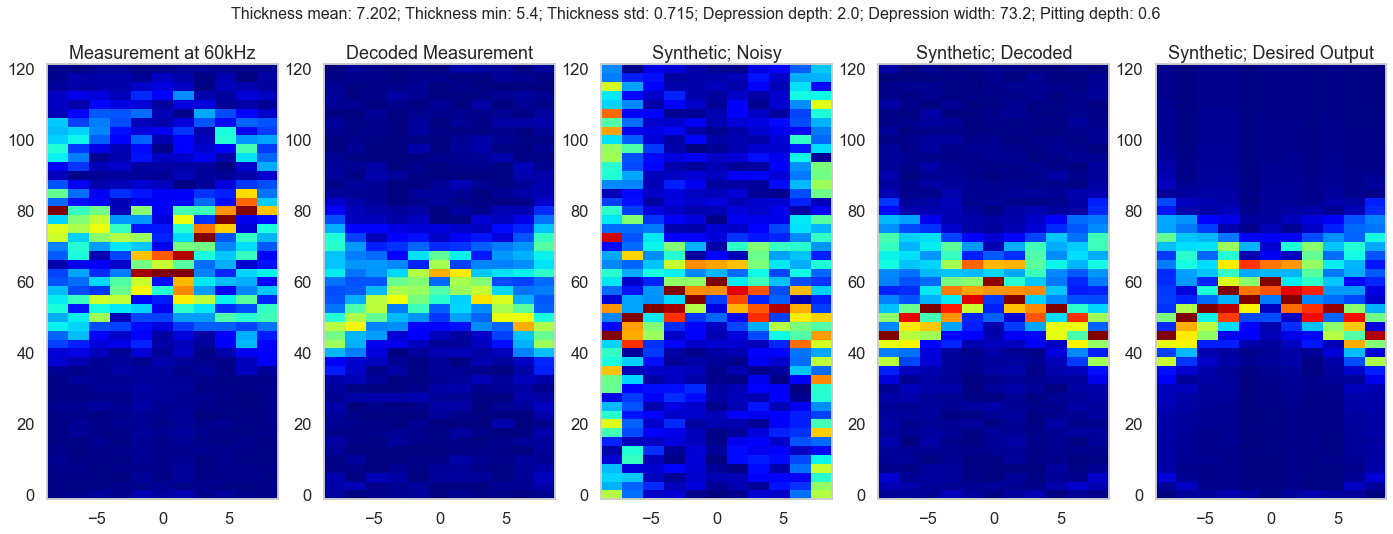

In [111]:
synthsample = 1095
synthsample = 933

titlestring = f"Thickness mean: {labels.iloc[synthsample]['Thickness mean']:.3f}; " \
              f"Thickness min: {labels.iloc[synthsample]['Thickness minimum']:.1f}; " \
              f"Thickness std: {labels.iloc[synthsample]['Thickness std']:.3f}; " \
              f"Depression depth: {labels.iloc[synthsample]['Depression depth']:.1f}; " \
              f"Depression width: {labels.iloc[synthsample]['Depression width']:.1f}; " \
              f"Pitting depth: {labels.iloc[synthsample]['Pitting depth']:.1f}"

plt.figure(figsize=(24,8))
plt.subplot(1,5,1)
plt.pcolormesh(x_array, f_array/1e3, measurements_fk[20, 0,:, :], cmap='jet', vmin=0, vmax=1)
plt.title('Measurement at ' + str(20+40) + 'kHz')
plt.subplot(1,5,2)
plt.pcolormesh(x_array, f_array/1e3, decoded_measurements_shaped_fk[20, 0,:, :], cmap='jet', vmin=0, vmax=1)
plt.title('Decoded Measurement')
plt.subplot(1,5,3)
plt.pcolormesh(x_array, f_array/1e3, X_sample_n_fk[synthsample, 0,:, :], cmap='jet', vmin=0, vmax=1)
plt.title('Synthetic; Noisy')
plt.subplot(1,5,4)
plt.pcolormesh(x_array, f_array/1e3, decode_sample(autoencoder_fk, X_sample_n_fk[synthsample,0,:,:]), cmap='jet', vmin=0, vmax=1)
plt.title('Synthetic; Decoded')
plt.subplot(1,5,5)
plt.pcolormesh(x_array, f_array/1e3, X_sample_c_fk[synthsample, 0,:,:], cmap='jet', vmin=0, vmax=1)
plt.title('Synthetic; Desired Output')
plt.suptitle(titlestring, fontsize=16)
plt.show()